# negotiating the past

We'll use ollama and llama3 7b to run some test.


We load the necessary libraries.

In [ ]:
!python --version
%pip install umap-learn
%pip install gensim
%pip install nltk
%pip install pandas
%pip install anthropic
%pip install ipywidgets


## Creating a Historical Prompt Dataset with Claude

## Import libraries and setup

In [1]:
# First cell - Import libraries and setup
import anthropic
import pandas as pd
import time
import logging
import os
from datetime import datetime
from tqdm.notebook import tqdm  # Note the use of tqdm.notebook for better display in Jupyter
from concurrent.futures import ThreadPoolExecutor
import json
import numpy as np

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f"past_reference_detection_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("past_reference_detector")

# Create results directory
os.makedirs("results", exist_ok=True)


## Load API key

In [2]:
# Second cell - Load API key securely
# Method 1: From a separate JSON file (recommended)
def load_api_key():
    try:
        # Try to load from config file
        with open('api_config.json') as f:
            config = json.load(f)
            return config.get('CLAUDE_API_KEY')
    except FileNotFoundError:
        # If file doesn't exist, check environment variables
        api_key = os.environ.get("CLAUDE_API_KEY")
        if api_key:
            return api_key
        else:
            # If not found, prompt user (only in notebook environment)
            from IPython.display import display
            from ipywidgets import widgets
            
            password = widgets.Password(
                description='Claude API Key:',
                style={'description_width': 'initial'},
                layout={'width': '50%'}
            )
            display(password)
            
            # This will allow the user to enter their API key securely
            # The entered key will be accessible via password.value in subsequent cells
            return None

# Create a JSON file for the API key that you won't commit to GitHub
# (Run this cell ONCE, then delete or comment it out)
"""
import json
with open('api_config.json', 'w') as f:
    json.dump({'CLAUDE_API_KEY': 'your_api_key_here'}, f)
    
print("Created api_config.json - add this file to .gitignore!")

# Create .gitignore if it doesn't exist
if not os.path.exists('.gitignore'):
    with open('.gitignore', 'w') as f:
        f.write("api_config.json\n.ipynb_checkpoints/\n__pycache__/\n*.pyc\nresults/\nlogs/\n")
    print("Created .gitignore file")
"""

# Load the API key
api_key = load_api_key()
if api_key and api_key.startswith("sk-"):
    print("✅ API key loaded successfully")
    # Initialize Claude client
    client = anthropic.Anthropic(api_key=api_key)
else:
    print("❌ API key not found or not valid format")
    # If using the widget approach, you'll need to get the value in the next cell
    # client = anthropic.Anthropic(api_key=password.value)

✅ API key loaded successfully


## Define your prompt

In [3]:
system_prompt = """As a panel of three historians with different specializations (international history, global history, and European history), analyze the following prompt to determine if it contains an implicit or explicit reference to the past.

Each historian should consider:

1. EXPLICIT REFERENCES: Clear temporal markers (yesterday, last week, previously), historical events, periods, or figures, or mentions of things that happened in the past.

2. IMPLICIT REFERENCES: Subtle indications of past time frames, comparative language suggesting change over time, or references to completed actions or states that are no longer current.

3. CONTEXTUAL CLUES: Words implying memory, reflection, or nostalgia; verbs in past tense that indicate historical events rather than hypotheticals.

4. DOMAIN-SPECIFIC PERSPECTIVES:
   - International historian: Look for references to international relations, treaties, wars, or cross-border interactions that occurred in the past
   - Global historian: Consider references to world systems, long-term global trends, or cross-cultural historical developments
   - European historian: Note references to European historical periods, events, or figures

After your individual analyses, debate any disagreements and reach a consensus.

Your final answer must be ONLY 'yes' or 'no' - nothing else.
"""


## define functions

In [4]:
# Third cell - Helper functions
def analyze_prompt(prompt, client, retries=3, backoff_factor=2):
    """Analyze a single prompt using Claude API"""
    for attempt in range(retries):
        try:
            response = client.messages.create(
                model="claude-3-7-sonnet-20250219",
                max_tokens=10,
                temperature=0,
                system=system_prompt,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            
            # Extract the yes/no response
            classification = response.content[0].text.strip().lower()
            # Normalize the response
            if "yes" in classification:
                return "yes"
            else:
                return "no"
                
        except Exception as e:
            if attempt < retries - 1:
                sleep_time = backoff_factor ** attempt
                logger.warning(f"Error on prompt: {e}. Retrying in {sleep_time}s...")
                time.sleep(sleep_time)
            else:
                logger.error(f"Failed after {retries} attempts: {e}")
                return "error"

def process_batch(batch_prompts, client, batch_id):
    """Process a batch of prompts"""
    results = []
    for prompt in tqdm(batch_prompts, desc=f"Batch {batch_id}"):
        result = analyze_prompt(prompt, client)
        results.append({"prompt": prompt, "references_past": result})
    
    # Save batch results
    batch_df = pd.DataFrame(results)
    batch_df.to_csv(f"results/batch_{batch_id}_results.csv", index=False)
    logger.info(f"Completed batch {batch_id} with {len(results)} prompts")
    return results

## Load your dataset

In [5]:
# Fourth cell - Load and explore dataset

# Method 1: load a sample
# Define the size of your sample
sample_size = 50000

# Determine the total number of rows in your dataset
total_rows = sum(1 for _ in open('data/prompts.csv')) - 1  # -1 for header

# Compute the probability of being selected for each line
skip_prob = 1 - sample_size / total_rows

# Use the skiprows parameter with a lambda function
prompts_df = pd.read_csv('data/prompts.csv', 
                      usecols=[0],  # First column only
                      skiprows=lambda x: x > 0 and np.random.random() < skip_prob)

# Convert the DataFrame to a list of prompts
prompts_list = prompts_df.iloc[:,0].tolist()

# Verify what we've created:
print(f"Number of prompts loaded: {len(prompts_list)}")
print("First 5 prompts:")
for i, prompt in enumerate(prompts_list[:5]):
    print(f"{i+1}. {prompt}")

Number of prompts loaded: 49368
First 5 prompts:
1. Henry Cavill as Link in The Legend of Zelda Breath of the Wild promo shoot, studio lighting
2. emma watson holding the hand of jfk
3. hyper realistic photographer taking a picture, magical, gems, jewels, gold, steampunk, cyberpunk utopia, painted by tom bagshaw, mucha, gaston bussiere, craig mullins, j. c. leyendecker 8 k
4. A Dodo bird perched atop a Saguaro cactus in the desert, digital art, trending on Artstation, high detail, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha.
5. Bjork climbs out of your TV screen towards you like Sadako, J-Horror, 90s, 35mm film


## Process a small test batch

In [6]:
# Fifth cell - Process a small test batch
# Test with a small batch first
test_batch = prompts_list[:5]  # Just 5 prompts for testing
test_results = process_batch(test_batch, client, "test")

# Display test results
test_df = pd.DataFrame(test_results)
display(test_df)

# Check if everything is working correctly
if len(test_df) == len(test_batch):
    print("✅ Test batch processed successfully!")
else:
    print("❌ Some issues with the test batch")

Batch test:   0%|          | 0/5 [00:00<?, ?it/s]

2025-05-07 12:40:25,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:26,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:27,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:28,440 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:29,446 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:29,454 - past_reference_detector - INFO - Completed batch test with 5 prompts


prompt references_past
0  Henry Cavill as Link in The Legend of Zelda Br...              no
1                emma watson holding the hand of jfk             yes
2  hyper realistic photographer taking a picture,...              no
3  A Dodo bird perched atop a Saguaro cactus in t...              no
4  Bjork climbs out of your TV screen towards you...             yes

✅ Test batch processed successfully!


## Configure and start main processing with optimized parameters

In [7]:
# Sixth cell - Configure and start main processing
# Configuration for full run
batch_size = 50
max_workers = 1  # Adjust based on rate limits and resources

# Split dataset into batches
batches = [prompts_list[i:i+batch_size] for i in range(0, len(prompts_list), batch_size)]
print(f"Split dataset into {len(batches)} batches of size {batch_size}")

# Check for existing results to resume
existing_batches = set()
for filename in os.listdir("results"):
    if filename.startswith("batch_") and filename.endswith("_claude_results.csv"):
        try:
            batch_id = int(filename.split("_")[1])
            existing_batches.add(batch_id)
        except:
            pass

# Get batches to process
remaining_batches = [(i, batch) for i, batch in enumerate(batches) if i not in existing_batches]
print(f"Resume status: {len(batches)-len(remaining_batches)} batches already completed, {len(remaining_batches)} remaining")

# Cost estimate (approximate)
avg_tokens_per_prompt = 50  # Adjust based on your data
total_prompts = len(prompts_list)
estimated_tokens = total_prompts * (avg_tokens_per_prompt + 10)  # Input + output
estimated_cost = estimated_tokens / 1000 * 0.015  # Adjust rate based on current pricing

print(f"Estimated API cost: ${estimated_cost:.2f} (based on approx. ${0.015}/1K tokens)")
print(f"Processing {len(remaining_batches)} batches with {batch_size} prompts each using {max_workers} workers")

# Ask for confirmation before proceeding with the full run
from IPython.display import display
from ipywidgets import widgets

confirm = widgets.Button(
    description='Start Processing',
    button_style='success',
    tooltip='Click to start processing all batches'
)
cancel = widgets.Button(
    description='Cancel',
    button_style='danger',
    tooltip='Cancel processing'
)

output = widgets.Output()

display(widgets.HBox([confirm, cancel]), output)

def on_confirm(b):
    with output:
        print("Starting processing...")
        # The actual processing code will be in the next cell
        
def on_cancel(b):
    with output:
        print("Processing cancelled.")

confirm.on_click(on_confirm)
cancel.on_click(on_cancel)

Split dataset into 988 batches of size 50
Resume status: 0 batches already completed, 988 remaining
Estimated API cost: $44.43 (based on approx. $0.015/1K tokens)
Processing 988 batches with 50 prompts each using 1 workers


Output()

## Execute processing (run after confirmation)

In [8]:
# Seventh cell - Execute processing (run after confirmation)
# Process batches with multiple threads
all_results = []

# Use tqdm to track overall progress
progress_bar = tqdm(total=len(remaining_batches), desc="Overall progress")

# Function to update progress
def update_progress(future):
    progress_bar.update(1)
    return future.result()

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for i, batch in remaining_batches:
        future = executor.submit(process_batch, batch, client, i)
        future.add_done_callback(update_progress)
        futures.append(future)
    
    # Wait for all futures to complete
    for future in futures:
        try:
            batch_results = future.result()
            all_results.extend(batch_results)
        except Exception as e:
            logger.error(f"Error processing batch: {e}")

progress_bar.close()

Overall progress:   0%|          | 0/988 [00:00<?, ?it/s]

Batch 0:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:40:30,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:31,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:31,839 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:32,730 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:33,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:34,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:35,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:36,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:40:37,534 - httpx - INFO - HTTP Request: POST https://api.

Batch 1:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:41:20,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:21,466 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:22,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:22,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:23,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:24,367 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:25,786 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:26,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:41:28,226 - httpx - INFO - HTTP Request: POST https://api.

Batch 2:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:42:08,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:09,683 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:10,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:11,439 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:12,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:14,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:15,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:16,575 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:17,684 - httpx - INFO - HTTP Request: POST https://api.

Batch 3:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:42:58,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:42:59,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:00,722 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:01,730 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:02,817 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:03,664 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:04,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:05,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:06,338 - httpx - INFO - HTTP Request: POST https://api.

Batch 4:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:43:45,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:46,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:47,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:48,345 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:49,132 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:49,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:51,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:52,238 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:43:53,136 - httpx - INFO - HTTP Request: POST https://api.

Batch 5:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:44:46,816 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:48,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:49,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:50,199 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:51,425 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:52,654 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:53,882 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:55,335 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:44:56,336 - httpx - INFO - HTTP Request: POST https://api.

Batch 6:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:45:46,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:47,653 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:48,784 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:49,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:51,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:52,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:53,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:55,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:45:55,987 - httpx - INFO - HTTP Request: POST https://api.

Batch 7:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:46:37,690 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:38,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:39,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:40,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:41,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:42,643 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:43,573 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:44,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:46:45,215 - httpx - INFO - HTTP Request: POST https://api.

Batch 8:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:47:37,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:47:37,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 12:47:37,641 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 12:47:38,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 12:47:38,819 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 12:47:40,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 12:47:40,996 - p

Batch 9:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:48:40,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:41,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:42,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:43,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:43,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:44,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:46,322 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:47,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:48:48,179 - httpx - INFO - HTTP Request: POST https://api.

Batch 10:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:49:32,942 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:33,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:34,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:36,123 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:37,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:37,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:38,866 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:39,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:49:40,750 - httpx - INFO - HTTP Request: POST https://api.

Batch 11:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:50:27,749 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:50:28,495 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:50:28,676 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:50:28,676 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:50:30,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:50:31,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:50:31,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:50:31,446 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:50:33,476 - httpx - INFO - HTTP Reques

Batch 12:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:51:30,753 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:31,695 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:32,721 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:33,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:34,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:35,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:36,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:38,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:51:39,084 - httpx - INFO - HTTP Request: POST https://api.

Batch 13:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:52:28,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:52:28,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:52:29,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:52:30,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:52:30,052 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:52:31,967 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:52:32,749 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:52:33,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:52:33,784 - httpx - INFO - HTTP Request: POST ht

Batch 14:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:53:28,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:29,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:30,940 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:31,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:32,793 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:33,753 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:34,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:35,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:53:36,489 - httpx - INFO - HTTP Request: POST https://api.

Batch 15:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:54:25,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:54:25,497 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:54:27,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:54:28,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:54:29,216 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:54:30,024 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:54:30,191 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:54:30,192 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:54:31,995 - httpx - INFO - HTTP Reques

Batch 16:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:55:25,015 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:55:25,169 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:55:25,171 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:55:27,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:55:28,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:55:29,394 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:55:30,967 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:55:31,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:55:32,901 - httpx - INFO - HTTP Request: POST ht

Batch 17:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:56:25,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:56:26,971 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:56:27,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:56:28,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:56:28,824 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:56:28,825 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:56:30,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:56:31,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:56:32,491 - httpx - INFO - HTTP Request: POST ht

Batch 18:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:57:25,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:57:25,397 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:57:25,398 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:57:27,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:57:28,656 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:57:29,476 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:57:30,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:57:31,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:57:31,376 - httpx - INFO - HTTP Request: POST ht

Batch 19:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:58:25,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:58:26,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:58:27,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:58:28,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:58:28,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:58:28,829 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:58:30,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:58:31,522 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:58:32,769 - httpx - INFO - HTTP Request: POST ht

Batch 20:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 12:59:23,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 12:59:23,820 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 12:59:26,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:59:27,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:59:28,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:59:29,653 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:59:30,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:59:32,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 12:59:32,932 - httpx - INFO - HTTP Request: POST ht

Batch 21:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:00:26,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:00:27,087 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:00:27,773 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:00:28,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:00:29,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:00:29,006 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:00:30,791 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:00:31,826 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:00:32,739 - httpx - INFO - HTTP Request: POST ht

Batch 22:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:01:26,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:01:27,220 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:01:27,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:01:29,009 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:01:30,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:01:30,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:01:30,251 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:01:32,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:01:33,420 - httpx - INFO - HTTP Request: POST ht

Batch 23:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:02:25,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:27,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:28,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:29,780 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:30,784 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:31,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:32,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:33,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:02:33,640 - httpx - INFO - HTTP Request: POST https://api.

Batch 24:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:03:25,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:27,009 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:28,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:29,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:30,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:31,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:33,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:34,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:03:34,975 - httpx - INFO - HTTP Request: POST https://api.

Batch 25:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:04:25,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:04:25,567 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 13:04:25,569 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 13:04:26,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 13:04:26,733 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 13:04:28,891 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 13:04:28,892 - p

Batch 26:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:05:24,727 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:25,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:26,572 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:27,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:30,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:31,117 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:32,143 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:33,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:05:34,303 - httpx - INFO - HTTP Request: POST https://api.

Batch 27:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:06:23,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:06:24,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:06:25,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:06:26,699 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:06:27,687 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:06:28,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:06:28,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:06:28,717 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:06:30,569 - httpx - INFO - HTTP Request: POST ht

Batch 28:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:07:24,045 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:07:24,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:07:25,659 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:07:26,507 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:07:27,745 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:07:28,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:07:28,936 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:07:28,937 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:07:30,922 - httpx - INFO - HTTP Request: POST ht

Batch 29:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:08:21,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:08:21,770 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:08:24,262 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:08:25,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:08:26,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:08:27,129 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:08:27,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:08:29,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:08:29,797 - httpx - INFO - HTTP Request: POST ht

Batch 30:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:09:23,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:09:23,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:09:23,971 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:09:23,973 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:09:26,218 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:09:27,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:09:28,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:09:29,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:09:31,342 - httpx - INFO - HTTP Request: POST ht

Batch 31:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:10:22,841 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:10:23,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:10:23,002 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:10:25,106 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:10:26,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:10:27,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:10:28,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:10:29,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:10:30,427 - httpx - INFO - HTTP Request: POST ht

Batch 32:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:11:24,185 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:25,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:26,132 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:26,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:27,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:28,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:30,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:31,554 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:11:32,613 - httpx - INFO - HTTP Request: POST https://api.

Batch 33:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:12:19,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:12:19,133 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:12:21,035 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:12:21,954 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:12:22,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:12:23,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:12:24,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 429 Too Many Requests"
2025-05-07 13:12:24,179 - anthropic._base_client - INFO - Retrying request to /v1/messages in 1.000000 seconds
2025-05-07 13:12:25,936 - httpx - INFO - HTTP Reques

Batch 34:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:13:22,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:23,678 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:24,705 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:25,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:27,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:28,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:29,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:30,143 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:13:30,954 - httpx - INFO - HTTP Request: POST https://api.

Batch 35:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:14:34,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:37,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:39,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:41,608 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:43,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:45,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:47,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:48,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:14:51,784 - httpx - INFO - HTTP Request: POST https://api.

Batch 36:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:15:45,951 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:47,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:48,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:48,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:50,228 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:52,067 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:53,298 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:54,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:15:55,852 - httpx - INFO - HTTP Request: POST https://api.

Batch 37:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:16:41,365 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:42,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:43,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:44,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:46,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:47,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:48,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:50,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:16:52,279 - httpx - INFO - HTTP Request: POST https://api.

Batch 38:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:17:50,303 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:17:51,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:17:52,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:17:53,950 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:17:56,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:17:57,709 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:17:58,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:18:00,167 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:18:00,998 - httpx - INFO - HTTP Request: POST https://api.

Batch 39:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:18:54,639 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:18:55,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:18:56,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:18:57,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:18:58,773 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:19:00,009 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:19:01,443 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:19:03,140 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:19:04,679 - httpx - INFO - HTTP Request: POST https://api.

Batch 40:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:20:02,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:03,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:04,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:06,103 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:06,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:07,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:08,690 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:09,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:20:10,508 - httpx - INFO - HTTP Request: POST https://api.

Batch 41:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:21:17,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:18,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:20,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:21,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:23,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:24,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:25,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:27,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:21:29,046 - httpx - INFO - HTTP Request: POST https://api.

Batch 42:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:22:31,829 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:33,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:34,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:36,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:37,670 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:40,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:42,062 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:43,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:22:44,623 - httpx - INFO - HTTP Request: POST https://api.

Batch 43:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:23:34,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:35,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:36,356 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:37,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:38,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:39,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:40,755 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:41,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:23:42,681 - httpx - INFO - HTTP Request: POST https://api.

Batch 44:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:24:34,317 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:35,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:37,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:38,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:39,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:40,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:41,267 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:42,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:24:43,728 - httpx - INFO - HTTP Request: POST https://api.

Batch 45:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:25:33,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:34,721 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:35,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:36,989 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:38,205 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:39,317 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:40,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:41,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:25:42,910 - httpx - INFO - HTTP Request: POST https://api.

Batch 46:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:26:27,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:28,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:29,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:30,771 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:32,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:33,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:34,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:35,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:26:36,508 - httpx - INFO - HTTP Request: POST https://api.

Batch 47:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:27:25,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:27,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:27,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:29,243 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:30,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:31,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:32,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:33,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:27:34,323 - httpx - INFO - HTTP Request: POST https://api.

Batch 48:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:28:23,904 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:25,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:26,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:27,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:28,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:29,490 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:30,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:31,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:28:33,923 - httpx - INFO - HTTP Request: POST https://api.

Batch 49:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:29:20,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:21,699 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:23,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:24,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:25,315 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:26,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:27,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:28,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:29:29,630 - httpx - INFO - HTTP Request: POST https://api.

Batch 50:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:30:20,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:22,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:22,933 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:24,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:25,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:26,565 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:28,295 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:29,832 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:30:30,697 - httpx - INFO - HTTP Request: POST https://api.

Batch 51:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:31:18,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:18,950 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:20,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:21,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:22,367 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:23,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:24,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:25,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:31:26,333 - httpx - INFO - HTTP Request: POST https://api.

Batch 52:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:32:17,352 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:18,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:19,205 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:20,317 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:21,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:22,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:23,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:24,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:32:26,166 - httpx - INFO - HTTP Request: POST https://api.

Batch 53:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:33:12,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:33:13,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:33:14,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:33:15,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:33:15,883 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 13:33:15,884 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 13:33:17,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 13:33:17,136 - past_reference_dete

Batch 54:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:34:11,590 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:12,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:13,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:14,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:16,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:18,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:21,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:23,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:34:25,409 - httpx - INFO - HTTP Request: POST https://api.

Batch 55:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:35:38,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:40,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:44,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:46,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:48,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:51,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:52,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:55,074 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:35:57,424 - httpx - INFO - HTTP Request: POST https://api.

Batch 56:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:38:38,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:38:42,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:38:46,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:38:49,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:38:53,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:38:55,203 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:39:00,110 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:39:02,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:39:11,949 - httpx - INFO - HTTP Request: POST https://api.

Batch 57:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:41:33,207 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:34,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:36,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:38,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:39,829 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:42,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:43,221 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:44,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:41:45,333 - httpx - INFO - HTTP Request: POST https://api.

Batch 58:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:42:42,817 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:43,878 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:44,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:45,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:47,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:47,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:49,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:50,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:42:51,532 - httpx - INFO - HTTP Request: POST https://api.

Batch 59:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:43:44,312 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:45,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:46,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:48,022 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:49,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:50,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:51,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:52,859 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:43:53,943 - httpx - INFO - HTTP Request: POST https://api.

Batch 60:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:44:41,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:42,719 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:44,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:45,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:46,559 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:47,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:48,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:49,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:44:51,205 - httpx - INFO - HTTP Request: POST https://api.

Batch 61:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:45:42,210 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:43,404 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:44,403 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:45,203 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:46,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:47,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:48,524 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:49,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:45:50,484 - httpx - INFO - HTTP Request: POST https://api.

Batch 62:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:46:38,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:39,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:40,312 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:42,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:43,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:44,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:45,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:46,581 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:46:47,759 - httpx - INFO - HTTP Request: POST https://api.

Batch 63:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:47:45,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:46,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:47,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:48,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:50,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:51,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:52,666 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:54,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:47:56,335 - httpx - INFO - HTTP Request: POST https://api.

Batch 64:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:48:46,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:48,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:50,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:51,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:52,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:53,528 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:54,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:55,771 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:48:56,743 - httpx - INFO - HTTP Request: POST https://api.

Batch 65:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:49:44,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:45,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:46,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:47,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:48,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:49,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:50,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:51,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:49:52,682 - httpx - INFO - HTTP Request: POST https://api.

Batch 66:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:50:38,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:39,854 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:41,709 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:42,807 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:44,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:45,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:46,308 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:47,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:50:48,276 - httpx - INFO - HTTP Request: POST https://api.

Batch 67:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:51:37,212 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:38,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:39,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:40,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:41,915 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:44,050 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:47,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:48,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:51:49,479 - httpx - INFO - HTTP Request: POST https://api.

Batch 68:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:52:46,713 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:47,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:48,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:50,388 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:51,418 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:52,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:53,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:54,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:52:55,824 - httpx - INFO - HTTP Request: POST https://api.

Batch 69:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:53:46,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:47,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:48,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:50,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:51,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:52,516 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:53,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:55,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:53:56,473 - httpx - INFO - HTTP Request: POST https://api.

Batch 70:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:54:48,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:50,048 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:51,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:52,708 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:54,580 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:55,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:56,664 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:58,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:54:59,445 - httpx - INFO - HTTP Request: POST https://api.

Batch 71:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:55:53,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:55:54,442 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:55:55,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:55:56,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:55:57,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:55:58,725 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:55:59,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:56:01,203 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:56:02,311 - httpx - INFO - HTTP Request: POST https://api.

Batch 72:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:56:56,163 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:56:57,243 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:56:58,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:56:59,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:57:00,960 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:57:01,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:57:02,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:57:03,866 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:57:04,802 - httpx - INFO - HTTP Request: POST https://api.

Batch 73:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:57:56,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:57:57,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:57:58,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:00,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:01,118 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:01,913 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:02,602 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:03,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:04,235 - httpx - INFO - HTTP Request: POST https://api.

Batch 74:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:58:55,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:56,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:57,287 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:58,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:58:58,935 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:59:00,110 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:59:01,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:59:02,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:59:03,992 - httpx - INFO - HTTP Request: POST https://api.

Batch 75:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 13:59:56,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:59:57,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 13:59:59,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:00,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:01,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:03,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:04,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:06,029 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:07,210 - httpx - INFO - HTTP Request: POST https://api.

Batch 76:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:00:51,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:52,406 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:53,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:54,464 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:55,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:57,547 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:58,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:00:59,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:01:00,005 - httpx - INFO - HTTP Request: POST https://api.

Batch 77:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:01:53,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:01:54,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:01:55,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:01:56,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:01:58,182 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:01:59,181 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:02:00,162 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:02:01,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:02:02,629 - httpx - INFO - HTTP Request: POST https://api.

Batch 78:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:02:56,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:02:57,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:02:59,104 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:03:01,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:03:02,305 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:03:04,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:03:06,050 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:03:07,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:03:08,124 - httpx - INFO - HTTP Request: POST https://api.

Batch 79:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:03:57,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:03:59,071 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:00,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:01,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:02,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:04,271 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:05,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:06,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:07,712 - httpx - INFO - HTTP Request: POST https://api.

Batch 80:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:04:56,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:57,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:04:59,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:05:00,303 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:05:01,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:05:02,912 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:05:04,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:05:04,266 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:05:04,267 - past_reference_detector - WARNING - E

Batch 81:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:05:59,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:05:59,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:06:00,747 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:06:02,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:06:03,472 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:06:04,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:06:05,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:06:06,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:06:08,039 - httpx - INFO - HTTP Request: POST https://api.

Batch 82:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:07:01,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:02,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:04,834 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:06,590 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:07,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:09,559 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:10,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:11,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:07:12,778 - httpx - INFO - HTTP Request: POST https://api.

Batch 83:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:08:07,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:08,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:09,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:09,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:10,855 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:11,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:12,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:14,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:08:15,187 - httpx - INFO - HTTP Request: POST https://api.

Batch 84:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:09:04,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:09:04,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:09:04,590 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 14:09:05,746 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:09:05,747 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 14:09:07,915 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:09:07,916 - p

Batch 85:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:10:06,913 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:07,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:08,816 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:09,974 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:11,106 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:12,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:13,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:14,428 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:10:16,433 - httpx - INFO - HTTP Request: POST https://api.

Batch 86:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:11:11,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:13,686 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:15,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:16,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:17,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:18,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:19,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:20,428 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:11:21,764 - httpx - INFO - HTTP Request: POST https://api.

Batch 87:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:12:11,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:13,167 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:14,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:15,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:16,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:17,675 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:18,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:20,439 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:12:22,092 - httpx - INFO - HTTP Request: POST https://api.

Batch 88:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:13:11,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:12,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:13,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:14,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:16,349 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:17,173 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:18,312 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:19,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:13:20,442 - httpx - INFO - HTTP Request: POST https://api.

Batch 89:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:14:13,099 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:13,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:15,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:16,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:18,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:20,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:21,381 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:22,308 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:14:23,100 - httpx - INFO - HTTP Request: POST https://api.

Batch 90:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:15:14,522 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:15:15,953 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:15:16,101 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:15:16,102 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 14:15:17,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:15:17,262 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 14:15:19,429 - httpx - IN

Batch 91:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:16:16,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:18,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:19,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:20,551 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:21,414 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:22,966 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:24,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:25,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:16:26,918 - httpx - INFO - HTTP Request: POST https://api.

Batch 92:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:17:30,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:32,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:34,093 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:35,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:36,929 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:37,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:38,929 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:39,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:17:41,788 - httpx - INFO - HTTP Request: POST https://api.

Batch 93:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:18:50,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:18:51,101 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:18:52,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:18:54,376 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:18:55,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:18:57,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:18:59,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:19:01,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:19:03,196 - httpx - INFO - HTTP Request: POST https://api.

Batch 94:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:20:02,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:03,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:04,730 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:06,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:07,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:08,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:10,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:11,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:20:13,024 - httpx - INFO - HTTP Request: POST https://api.

Batch 95:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:21:16,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:17,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:18,485 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:19,208 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:20,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:21,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:23,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:24,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:21:26,113 - httpx - INFO - HTTP Request: POST https://api.

Batch 96:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:22:34,758 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:37,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:39,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:41,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:43,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:44,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:46,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:48,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:22:49,715 - httpx - INFO - HTTP Request: POST https://api.

Batch 97:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:23:46,466 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:47,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:49,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:50,891 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:52,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:53,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:54,710 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:55,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:23:57,000 - httpx - INFO - HTTP Request: POST https://api.

Batch 98:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:25:07,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:10,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:11,253 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:13,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:14,879 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:16,877 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:18,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:19,440 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:25:20,637 - httpx - INFO - HTTP Request: POST https://api.

Batch 99:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:26:25,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:26,771 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:28,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:29,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:30,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:31,895 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:33,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:34,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:26:36,655 - httpx - INFO - HTTP Request: POST https://api.

Batch 100:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:27:34,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:35,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:36,905 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:38,086 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:39,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:42,199 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:44,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:45,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:27:46,692 - httpx - INFO - HTTP Request: POST https://api.

Batch 101:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:28:52,228 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:28:53,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:28:54,688 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:28:56,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:28:58,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:28:59,705 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:29:00,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:29:01,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:29:04,849 - httpx - INFO - HTTP Request: POST https://api.

Batch 102:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:30:06,365 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:07,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:08,746 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:09,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:11,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:12,817 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:14,355 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:15,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:30:16,853 - httpx - INFO - HTTP Request: POST https://api.

Batch 103:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:31:24,298 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:26,170 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:27,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:29,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:30,210 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:31,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:32,489 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:33,924 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:31:35,250 - httpx - INFO - HTTP Request: POST https://api.

Batch 104:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:32:38,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:40,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:41,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:43,472 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:44,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:46,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:48,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:49,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:32:51,031 - httpx - INFO - HTTP Request: POST https://api.

Batch 105:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:33:49,912 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:33:51,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:33:52,567 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:33:53,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:33:55,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:33:57,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:33:58,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:34:00,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:34:02,055 - httpx - INFO - HTTP Request: POST https://api.

Batch 106:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:35:06,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:08,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:10,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:11,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:12,659 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:13,994 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:15,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:16,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:35:18,796 - httpx - INFO - HTTP Request: POST https://api.

Batch 107:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:36:23,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:25,276 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:27,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:28,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:30,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:31,405 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:32,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:34,994 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:36:37,653 - httpx - INFO - HTTP Request: POST https://api.

Batch 108:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:37:39,181 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:37:39,183 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 14:37:40,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:37:40,438 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 14:37:42,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:37:42,606 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 109:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:38:45,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:46,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:47,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:49,353 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:51,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:52,638 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:54,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:56,015 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:38:57,754 - httpx - INFO - HTTP Request: POST https://api.

Batch 110:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:39:59,377 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:01,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:03,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:04,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:05,337 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:06,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:07,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:09,191 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:40:10,503 - httpx - INFO - HTTP Request: POST https://api.

Batch 111:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:41:06,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:07,989 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:09,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:10,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:11,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:12,635 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:14,481 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:16,322 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:41:17,407 - httpx - INFO - HTTP Request: POST https://api.

Batch 112:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:42:11,755 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:12,656 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:13,644 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:14,626 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:15,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:16,824 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:17,745 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:18,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:42:20,408 - httpx - INFO - HTTP Request: POST https://api.

Batch 113:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:43:08,738 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:09,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:10,792 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:12,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:12,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:14,074 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:14,991 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:15,984 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:43:18,652 - httpx - INFO - HTTP Request: POST https://api.

Batch 114:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:44:09,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:10,905 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:12,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:12,953 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:14,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:15,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:16,842 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:18,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:44:20,322 - httpx - INFO - HTTP Request: POST https://api.

Batch 115:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:45:09,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:10,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:11,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:12,719 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:13,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:14,855 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:16,507 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:17,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:45:18,359 - httpx - INFO - HTTP Request: POST https://api.

Batch 116:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:46:07,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:09,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:09,893 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:11,023 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:12,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:13,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:14,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:15,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:46:17,254 - httpx - INFO - HTTP Request: POST https://api.

Batch 117:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:47:05,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:06,647 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:07,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:09,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:10,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:12,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:13,298 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:14,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:47:15,541 - httpx - INFO - HTTP Request: POST https://api.

Batch 118:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:48:03,357 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:05,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:06,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:07,349 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:08,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:09,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:10,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:11,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:48:12,073 - httpx - INFO - HTTP Request: POST https://api.

Batch 119:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:49:00,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:02,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:03,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:04,507 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:05,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:06,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:07,982 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:09,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:49:10,742 - httpx - INFO - HTTP Request: POST https://api.

Batch 120:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:50:10,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:11,775 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:13,003 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:14,566 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:15,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:17,816 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:18,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:19,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:50:23,019 - httpx - INFO - HTTP Request: POST https://api.

Batch 121:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:51:18,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:19,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:20,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:22,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:22,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:23,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:24,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:26,015 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:51:27,056 - httpx - INFO - HTTP Request: POST https://api.

Batch 122:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:52:18,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:19,825 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:21,321 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:22,656 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:23,727 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:25,102 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:26,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:27,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:52:28,241 - httpx - INFO - HTTP Request: POST https://api.

Batch 123:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:53:34,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:53:36,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:53:37,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:53:39,605 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:53:41,394 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:53:43,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:53:44,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:53:44,695 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 14:53:44,696 - past_reference_detector - WARNING - E

Batch 124:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:54:44,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:46,375 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:47,605 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:48,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:49,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:50,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:51,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:53,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:54:55,392 - httpx - INFO - HTTP Request: POST https://api.

Batch 125:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:56:09,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:12,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:13,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:14,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:15,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:17,410 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:18,572 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:20,688 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:56:22,941 - httpx - INFO - HTTP Request: POST https://api.

Batch 126:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:57:50,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:57:52,541 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:57:54,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:57:55,043 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:57:56,298 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:57:58,267 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:57:59,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:58:01,940 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:58:04,213 - httpx - INFO - HTTP Request: POST https://api.

Batch 127:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 14:59:03,826 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:05,056 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:06,982 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:08,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:09,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:11,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:13,031 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:14,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 14:59:16,208 - httpx - INFO - HTTP Request: POST https://api.

Batch 128:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:00:28,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:33,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:35,131 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:36,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:38,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:40,335 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:42,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:44,192 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:00:45,497 - httpx - INFO - HTTP Request: POST https://api.

Batch 129:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:01:49,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:01:49,393 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 15:01:50,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:01:50,562 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 15:01:52,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:01:52,758 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 130:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:02:54,822 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:02:55,664 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:02:57,942 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:02:59,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:02:59,960 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:03:00,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:03:01,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:03:03,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:03:04,245 - httpx - INFO - HTTP Request: POST https://api.

Batch 131:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:03:59,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:01,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:02,838 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:03,688 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:05,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:06,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:08,209 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:09,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:04:09,991 - httpx - INFO - HTTP Request: POST https://api.

Batch 132:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:05:01,443 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:02,475 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:03,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:04,481 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:05,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:06,167 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:07,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:08,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:05:08,977 - httpx - INFO - HTTP Request: POST https://api.

Batch 133:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:06:03,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:05,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:06,814 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:07,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:09,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:10,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:11,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:12,440 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:06:14,343 - httpx - INFO - HTTP Request: POST https://api.

Batch 134:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:07:09,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:10,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:11,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:12,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:13,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:14,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:15,643 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:16,611 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:07:17,737 - httpx - INFO - HTTP Request: POST https://api.

Batch 135:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:08:16,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:08:18,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:08:19,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:08:21,018 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:08:22,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:08:22,550 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:08:22,553 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 15:08:23,716 - httpx - INFO - HTTP Request:

Batch 136:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:09:21,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:23,727 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:25,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:26,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:29,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:31,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:33,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:34,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:09:36,165 - httpx - INFO - HTTP Request: POST https://api.

Batch 137:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:10:29,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:30,495 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:31,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:32,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:33,515 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:35,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:36,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:37,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:10:38,711 - httpx - INFO - HTTP Request: POST https://api.

Batch 138:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:11:32,700 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:33,877 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:34,952 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:37,159 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:39,086 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:39,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:41,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:42,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:11:42,824 - httpx - INFO - HTTP Request: POST https://api.

Batch 139:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:12:36,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:37,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:38,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:40,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:41,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:43,034 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:44,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:45,650 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:12:46,477 - httpx - INFO - HTTP Request: POST https://api.

Batch 140:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:13:42,379 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:45,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:46,989 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:48,276 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:49,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:51,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:53,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:55,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:13:56,920 - httpx - INFO - HTTP Request: POST https://api.

Batch 141:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:14:58,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:14:59,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:15:01,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:15:02,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:15:03,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:15:04,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:15:05,545 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:15:06,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:15:07,679 - httpx - INFO - HTTP Request: POST https://api.

Batch 142:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:16:10,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:12,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:14,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:15,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:17,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:18,701 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:20,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:22,702 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:16:23,919 - httpx - INFO - HTTP Request: POST https://api.

Batch 143:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:18:03,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:05,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:07,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:09,429 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:12,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:14,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:16,989 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:18,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:18:24,245 - httpx - INFO - HTTP Request: POST https://api.

Batch 144:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:20:33,295 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:20:35,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:20:43,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:20:48,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:20:51,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:20:56,351 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:21:06,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-07 15:21:06,970 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.453233 seconds
2025-05-07 15:21:13,237 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 145:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:23:12,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:13,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:17,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:19,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:26,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:34,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:36,711 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:39,889 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:23:43,530 - httpx - INFO - HTTP Request: POST https://api.

Batch 146:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:25:50,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:25:52,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:25:55,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:25:57,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:26:01,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:26:03,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:26:07,737 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:26:12,675 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:26:19,301 - httpx - INFO - HTTP Request: POST https://api.

Batch 147:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:27:48,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:27:49,515 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:27:51,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:27:52,377 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:27:55,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:27:57,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:27:59,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:28:01,473 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:28:03,695 - httpx - INFO - HTTP Request: POST https://api.

Batch 148:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:29:14,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:16,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:18,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:20,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:24,173 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:25,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:27,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:28,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:29:30,686 - httpx - INFO - HTTP Request: POST https://api.

Batch 149:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:31:07,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:09,210 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:10,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:13,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:16,365 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:22,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:24,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:25,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:31:27,678 - httpx - INFO - HTTP Request: POST https://api.

Batch 150:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:32:55,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:32:57,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:32:59,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:33:01,019 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:33:03,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:33:04,495 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:33:06,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:33:07,718 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:33:09,802 - httpx - INFO - HTTP Request: POST https://api.

Batch 151:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:34:34,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:39,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:41,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:44,219 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:46,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:47,650 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:52,520 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:53,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:34:55,672 - httpx - INFO - HTTP Request: POST https://api.

Batch 152:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:36:55,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:36:57,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:37:00,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:37:02,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:37:05,145 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:37:08,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:37:10,561 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:37:13,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:37:15,914 - httpx - INFO - HTTP Request: POST https://api.

Batch 153:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:38:44,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:46,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:47,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:48,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:50,300 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:52,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:54,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:56,181 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:38:57,933 - httpx - INFO - HTTP Request: POST https://api.

Batch 154:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:40:27,527 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:28,718 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:30,710 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:32,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:34,338 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:36,081 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:37,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:39,816 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:40:41,532 - httpx - INFO - HTTP Request: POST https://api.

Batch 155:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:41:56,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:41:57,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:41:57,029 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 15:41:58,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:41:58,373 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 15:42:00,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:42:00,540 - p

Batch 156:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:43:24,412 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:26,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:27,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:29,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:31,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:33,151 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:36,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:37,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:43:39,584 - httpx - INFO - HTTP Request: POST https://api.

Batch 157:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:45:12,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:14,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:16,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:19,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:21,944 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:23,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:24,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:26,092 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:45:30,475 - httpx - INFO - HTTP Request: POST https://api.

Batch 158:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:46:46,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:46:48,081 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:46:49,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:46:49,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:46:49,374 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 15:46:50,559 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 15:46:50,560 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 159:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:48:28,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:30,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:31,851 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:33,279 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:35,357 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:36,854 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:39,129 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:40,695 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:48:42,578 - httpx - INFO - HTTP Request: POST https://api.

Batch 160:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:49:51,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:49:53,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:49:54,621 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:49:56,034 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:49:57,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:49:58,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:49:59,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:50:01,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:50:02,907 - httpx - INFO - HTTP Request: POST https://api.

Batch 161:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:51:18,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:20,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:22,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:24,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:27,099 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:28,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:32,279 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:34,063 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:51:35,603 - httpx - INFO - HTTP Request: POST https://api.

Batch 162:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:53:06,203 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:08,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:12,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:14,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:17,181 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:21,512 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:22,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:24,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:53:24,371 - httpx - INFO - HTTP Request: POST https://api.

Batch 163:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:54:55,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:01,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:03,048 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:04,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:09,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:12,253 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:14,538 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:15,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:55:19,329 - httpx - INFO - HTTP Request: POST https://api.

Batch 164:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:56:34,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:35,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:38,106 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:40,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:42,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:44,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:46,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:48,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:56:50,972 - httpx - INFO - HTTP Request: POST https://api.

Batch 165:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:57:58,485 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:00,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:01,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:04,494 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:06,027 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:07,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:10,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:11,559 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:58:12,934 - httpx - INFO - HTTP Request: POST https://api.

Batch 166:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 15:59:28,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:30,546 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:31,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:33,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:36,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:37,775 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:39,421 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:40,985 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 15:59:42,481 - httpx - INFO - HTTP Request: POST https://api.

Batch 167:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:01:17,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:19,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:22,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:23,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:24,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:26,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:28,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:30,167 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:01:31,522 - httpx - INFO - HTTP Request: POST https://api.

Batch 168:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:03:05,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:07,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:09,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:10,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:12,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:14,015 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:15,840 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:18,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:03:19,358 - httpx - INFO - HTTP Request: POST https://api.

Batch 169:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:04:52,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:04:53,654 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:04:55,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:04:56,293 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:04:58,035 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:04:59,163 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:05:01,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:05:02,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:05:02,601 - httpx - INFO - HTTP Request: POST https://api.

Batch 170:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:07:19,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:07:21,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:07:23,899 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:07:27,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:07:27,953 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:07:27,956 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 16:07:29,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:07:29,128 - past_reference_dete

Batch 171:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:09:45,376 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:09:47,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:09:51,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:09:53,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:09:55,649 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:09:57,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:09:59,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:10:01,355 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:10:03,201 - httpx - INFO - HTTP Request: POST https://api.

Batch 172:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:11:21,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:11:23,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:11:25,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:11:26,550 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:11:27,889 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:11:28,062 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:11:28,064 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 16:11:29,222 - httpx - INFO - HTTP Request:

Batch 173:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:13:08,344 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:10,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:12,023 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:14,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:15,832 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:17,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:19,403 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:20,627 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:13:22,557 - httpx - INFO - HTTP Request: POST https://api.

Batch 174:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:14:28,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:30,708 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:32,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:34,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:37,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:38,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:39,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:40,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:14:43,180 - httpx - INFO - HTTP Request: POST https://api.

Batch 175:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:15:55,262 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:15:56,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:15:58,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:15:59,409 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:16:02,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:16:03,713 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:16:05,170 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:16:06,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:16:07,860 - httpx - INFO - HTTP Request: POST https://api.

Batch 176:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:17:16,663 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:17:17,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:17:19,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:17:22,106 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:17:22,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:17:22,260 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 16:17:23,439 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:17:23,440 - past_reference_dete

Batch 177:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:18:36,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:39,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:41,896 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:43,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:44,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:45,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:47,062 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:48,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:18:51,393 - httpx - INFO - HTTP Request: POST https://api.

Batch 178:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:19:54,998 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:19:55,860 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:19:57,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:19:59,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:20:00,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:20:02,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:20:03,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:20:05,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:20:06,258 - httpx - INFO - HTTP Request: POST https://api.

Batch 179:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:21:03,590 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:04,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:06,212 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:07,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:08,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:10,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:11,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:12,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:21:13,246 - httpx - INFO - HTTP Request: POST https://api.

Batch 180:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:22:10,565 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:11,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:12,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:13,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:15,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:15,999 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:18,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:19,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:22:20,407 - httpx - INFO - HTTP Request: POST https://api.

Batch 181:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:23:18,974 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:20,019 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:21,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:23,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:24,692 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:25,741 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:26,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:28,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:23:29,420 - httpx - INFO - HTTP Request: POST https://api.

Batch 182:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:24:25,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:26,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:27,975 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:28,970 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:30,023 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:31,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:32,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:33,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:24:34,966 - httpx - INFO - HTTP Request: POST https://api.

Batch 183:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:25:32,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:33,838 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:35,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:36,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:38,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:39,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:40,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:42,023 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:25:43,468 - httpx - INFO - HTTP Request: POST https://api.

Batch 184:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:26:39,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:33:20,645 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.413606 seconds
2025-05-07 16:33:22,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:33:23,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:33:25,043 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:33:26,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:33:27,663 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:33:28,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:33:30,419 - httpx - INFO - HTTP Request: POST https://api.anthr

Batch 185:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:34:33,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:34:34,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:34:36,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:34:36,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:34:36,904 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 16:34:38,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:34:38,298 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 186:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:35:45,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:46,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:47,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:49,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:49,936 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:50,824 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:51,708 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:52,851 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:35:54,215 - httpx - INFO - HTTP Request: POST https://api.

Batch 187:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:36:48,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:36:49,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:36:49,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:36:49,870 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 16:36:51,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:36:51,081 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 16:36:53,258 - httpx - IN

Batch 188:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:37:59,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:00,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:02,293 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:03,157 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:04,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:06,196 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:08,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:09,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:38:11,175 - httpx - INFO - HTTP Request: POST https://api.

Batch 189:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:39:29,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:30,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:34,940 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:40,154 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:41,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:44,602 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:45,708 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:47,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:39:49,732 - httpx - INFO - HTTP Request: POST https://api.

Batch 190:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:41:27,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:31,293 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:34,651 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:35,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:36,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:38,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:39,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:41,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:41:42,875 - httpx - INFO - HTTP Request: POST https://api.

Batch 191:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:43:28,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:30,083 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:32,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:33,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:38,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:40,327 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:42,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:49,220 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:43:50,144 - httpx - INFO - HTTP Request: POST https://api.

Batch 192:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:45:17,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:45:18,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:45:20,371 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:45:20,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:45:20,601 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 16:45:21,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:45:21,798 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 193:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:46:50,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:46:52,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:46:53,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:46:55,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:46:56,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:46:58,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:47:00,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:47:02,130 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:47:03,243 - httpx - INFO - HTTP Request: POST https://api.

Batch 194:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:47:58,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:47:59,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:48:00,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:48:01,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:48:03,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:48:04,779 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:48:05,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:48:07,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:48:08,786 - httpx - INFO - HTTP Request: POST https://api.

Batch 195:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:49:02,103 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:03,107 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:04,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:05,410 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:06,446 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:07,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:09,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:10,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:49:11,567 - httpx - INFO - HTTP Request: POST https://api.

Batch 196:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:50:04,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:05,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:06,144 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:07,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:08,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:09,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:10,832 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:11,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:50:12,800 - httpx - INFO - HTTP Request: POST https://api.

Batch 197:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:51:05,435 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:06,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:07,611 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:08,924 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:10,312 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:11,451 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:12,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:14,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:51:17,943 - httpx - INFO - HTTP Request: POST https://api.

Batch 198:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:52:12,196 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:13,467 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:14,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:16,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:17,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:18,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:19,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:20,253 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:52:21,977 - httpx - INFO - HTTP Request: POST https://api.

Batch 199:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:53:08,151 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:09,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:10,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:11,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:13,167 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:14,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:15,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:17,725 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:53:18,854 - httpx - INFO - HTTP Request: POST https://api.

Batch 200:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:54:15,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:16,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:18,117 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:25,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:26,651 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:28,083 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:29,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:30,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:54:31,671 - httpx - INFO - HTTP Request: POST https://api.

Batch 201:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:55:19,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:55:21,547 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:55:21,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:55:21,691 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 16:55:22,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 16:55:22,873 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 16:55:25,054 - httpx - IN

Batch 202:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:56:31,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:32,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:33,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:35,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:36,299 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:37,138 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:38,041 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:38,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:56:40,088 - httpx - INFO - HTTP Request: POST https://api.

Batch 203:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:57:35,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:36,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:37,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:38,891 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:39,779 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:40,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:41,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:42,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:57:43,789 - httpx - INFO - HTTP Request: POST https://api.

Batch 204:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:58:32,421 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:33,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:34,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:35,935 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:37,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:39,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:40,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:41,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:58:42,456 - httpx - INFO - HTTP Request: POST https://api.

Batch 205:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 16:59:31,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:32,639 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:33,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:35,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:36,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:37,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:38,708 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:39,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 16:59:40,436 - httpx - INFO - HTTP Request: POST https://api.

Batch 206:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:00:32,852 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:34,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:36,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:37,160 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:38,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:39,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:40,632 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:41,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:00:43,090 - httpx - INFO - HTTP Request: POST https://api.

Batch 207:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:01:35,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:36,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:37,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:38,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:39,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:40,840 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:41,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:42,487 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:01:43,506 - httpx - INFO - HTTP Request: POST https://api.

Batch 208:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:02:48,231 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:02:49,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:02:51,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:02:52,741 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:02:53,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:02:55,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:02:56,753 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:03:00,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:03:03,088 - httpx - INFO - HTTP Request: POST https://api.

Batch 209:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:04:47,852 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:04:49,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:04:51,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:04:52,639 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:04:54,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:04:56,759 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:04:59,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:05:01,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:05:08,525 - httpx - INFO - HTTP Request: POST https://api.

Batch 210:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:06:10,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:12,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:13,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:14,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:15,878 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:16,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:18,565 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:19,891 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:06:21,228 - httpx - INFO - HTTP Request: POST https://api.

Batch 211:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:07:14,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:15,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:16,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:17,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:18,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:19,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:20,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:21,944 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:07:23,086 - httpx - INFO - HTTP Request: POST https://api.

Batch 212:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:08:16,638 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:17,758 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:19,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:20,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:21,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:22,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:23,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:24,317 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:08:25,953 - httpx - INFO - HTTP Request: POST https://api.

Batch 213:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:09:17,573 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:18,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:19,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:20,563 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:21,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:22,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:24,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:25,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:09:26,785 - httpx - INFO - HTTP Request: POST https://api.

Batch 214:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:10:19,826 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:20,951 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:22,100 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:23,925 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:24,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:26,095 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:27,092 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:28,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:10:29,341 - httpx - INFO - HTTP Request: POST https://api.

Batch 215:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:11:24,238 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:25,975 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:27,352 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:29,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:30,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:31,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:33,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:35,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:11:37,453 - httpx - INFO - HTTP Request: POST https://api.

Batch 216:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:12:37,771 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:39,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:40,422 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:41,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:42,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:44,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:45,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:46,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:12:47,832 - httpx - INFO - HTTP Request: POST https://api.

Batch 217:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:13:39,466 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:40,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:41,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:43,182 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:44,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:45,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:47,210 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:48,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:13:49,493 - httpx - INFO - HTTP Request: POST https://api.

Batch 218:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:14:37,568 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:38,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:39,719 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:40,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:42,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:43,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:44,429 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:45,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:14:46,888 - httpx - INFO - HTTP Request: POST https://api.

Batch 219:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:15:40,242 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:41,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:42,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:43,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:44,531 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:46,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:46,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:48,219 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:15:49,366 - httpx - INFO - HTTP Request: POST https://api.

Batch 220:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:16:46,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:46,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:48,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:49,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:50,901 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:51,780 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:52,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:53,966 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:16:55,195 - httpx - INFO - HTTP Request: POST https://api.

Batch 221:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:18:15,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:18,321 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:19,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:23,597 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:25,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:27,987 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:34,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:42,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:18:53,297 - httpx - INFO - HTTP Request: POST https://api.

Batch 222:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:20:58,882 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:21:00,455 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:21:02,971 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:21:04,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:21:05,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 17:21:05,089 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 17:21:06,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 17:21:06,247 - past_reference_dete

Batch 223:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:23:13,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:14,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:16,027 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:17,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:18,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:19,428 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:20,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:21,860 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:23:22,895 - httpx - INFO - HTTP Request: POST https://api.

Batch 224:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:24:13,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:24:15,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:24:16,110 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:24:16,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:24:17,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:24:18,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 17:24:18,121 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 17:24:19,289 - httpx - INFO - HTTP Request:

Batch 225:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:25:18,479 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:20,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:21,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:22,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:23,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:25,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:26,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:27,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:25:28,988 - httpx - INFO - HTTP Request: POST https://api.

Batch 226:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:26:23,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:23,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:24,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:26,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:27,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:28,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:29,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:30,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:26:31,926 - httpx - INFO - HTTP Request: POST https://api.

Batch 227:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:27:25,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:27,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:28,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:29,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:30,807 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:31,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:33,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:34,899 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:27:35,836 - httpx - INFO - HTTP Request: POST https://api.

Batch 228:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:28:35,942 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:37,370 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:38,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:39,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:39,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:41,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:42,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:44,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:28:45,522 - httpx - INFO - HTTP Request: POST https://api.

Batch 229:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:29:37,990 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:39,725 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:40,948 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:41,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:42,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:43,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:44,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:46,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:29:47,514 - httpx - INFO - HTTP Request: POST https://api.

Batch 230:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:30:42,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:43,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:45,027 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:45,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:47,118 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:48,644 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:49,475 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:51,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:30:51,841 - httpx - INFO - HTTP Request: POST https://api.

Batch 231:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:31:38,951 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:39,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:40,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:42,522 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:43,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:45,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:46,439 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:47,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:31:48,505 - httpx - INFO - HTTP Request: POST https://api.

Batch 232:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:32:43,957 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:44,970 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:46,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:47,860 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:49,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:50,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:51,349 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:52,479 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:32:53,659 - httpx - INFO - HTTP Request: POST https://api.

Batch 233:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:33:41,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:42,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:44,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:45,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:46,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:46,998 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:48,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:49,029 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:33:50,029 - httpx - INFO - HTTP Request: POST https://api.

Batch 234:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:34:39,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:41,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:42,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:43,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:45,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:47,106 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:50,074 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:52,412 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:34:53,384 - httpx - INFO - HTTP Request: POST https://api.

Batch 235:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:35:45,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:46,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:48,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:49,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:50,382 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:51,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:52,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:53,008 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:35:53,998 - httpx - INFO - HTTP Request: POST https://api.

Batch 236:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:36:41,162 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:36:42,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:36:44,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:36:45,172 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:36:45,904 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:36:46,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:36:46,943 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 17:36:46,944 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 237:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:37:40,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:41,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:43,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:44,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:45,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:46,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:47,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:48,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:37:49,651 - httpx - INFO - HTTP Request: POST https://api.

Batch 238:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:38:34,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:35,220 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:36,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:37,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:38,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:39,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:40,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:41,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:38:42,707 - httpx - INFO - HTTP Request: POST https://api.

Batch 239:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:39:34,814 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:36,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:37,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:38,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:39,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:42,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:44,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:46,389 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:39:48,174 - httpx - INFO - HTTP Request: POST https://api.

Batch 240:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:42:27,999 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:30,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:31,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:36,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:38,112 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:41,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:46,174 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:47,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:42:49,650 - httpx - INFO - HTTP Request: POST https://api.

Batch 241:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:45:17,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:18,872 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:22,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:24,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:34,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:37,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:38,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:41,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:45:43,702 - httpx - INFO - HTTP Request: POST https://api.

Batch 242:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:46:43,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:44,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:46,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:47,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:48,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:50,099 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:50,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:52,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:46:53,141 - httpx - INFO - HTTP Request: POST https://api.

Batch 243:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:48:25,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:26,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:27,572 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:28,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:30,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:31,267 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:32,251 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:33,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:48:34,648 - httpx - INFO - HTTP Request: POST https://api.

Batch 244:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:49:21,102 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:49:21,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:49:22,701 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:49:23,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:49:25,138 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:49:25,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:49:26,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 17:49:26,077 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 245:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:50:23,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:50:24,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:50:25,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:50:26,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:50:27,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:50:28,531 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:50:28,683 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 17:50:28,684 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 246:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:51:24,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:25,872 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:26,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:27,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:28,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:29,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:30,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:31,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:51:32,525 - httpx - INFO - HTTP Request: POST https://api.

Batch 247:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:52:24,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:26,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:26,998 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:27,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:28,950 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:29,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:31,210 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:32,427 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:52:33,447 - httpx - INFO - HTTP Request: POST https://api.

Batch 248:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:53:23,988 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:24,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:25,583 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:26,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:27,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:29,568 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:30,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:31,950 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:53:32,943 - httpx - INFO - HTTP Request: POST https://api.

Batch 249:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:54:19,543 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:20,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:21,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:23,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:24,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:24,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:25,987 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:27,218 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:54:27,962 - httpx - INFO - HTTP Request: POST https://api.

Batch 250:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:55:13,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:14,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:15,040 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:16,159 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:17,220 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:18,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:19,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:20,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:55:21,916 - httpx - INFO - HTTP Request: POST https://api.

Batch 251:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:56:19,271 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:20,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:21,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:22,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:23,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:24,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:25,597 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:26,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:56:28,498 - httpx - INFO - HTTP Request: POST https://api.

Batch 252:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:57:13,718 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:14,954 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:16,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:17,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:18,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:19,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:20,397 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:21,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:57:22,540 - httpx - INFO - HTTP Request: POST https://api.

Batch 253:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:58:09,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:10,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:11,019 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:12,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:12,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:14,042 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:15,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:16,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:58:17,426 - httpx - INFO - HTTP Request: POST https://api.

Batch 254:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 17:59:29,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:31,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:32,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:33,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:36,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:37,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:38,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:39,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 17:59:40,474 - httpx - INFO - HTTP Request: POST https://api.

Batch 255:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:00:43,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:45,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:47,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:48,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:49,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:50,695 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:52,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:53,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:00:54,885 - httpx - INFO - HTTP Request: POST https://api.

Batch 256:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:02:05,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:06,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:08,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:09,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:10,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:11,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:13,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:14,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:02:16,917 - httpx - INFO - HTTP Request: POST https://api.

Batch 257:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:03:27,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:29,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:33,022 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:33,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:34,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:35,985 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:37,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:39,397 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:03:40,480 - httpx - INFO - HTTP Request: POST https://api.

Batch 258:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:05:02,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:03,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:05,087 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:06,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:08,344 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:09,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:11,725 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:12,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:05:13,550 - httpx - INFO - HTTP Request: POST https://api.

Batch 259:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:06:18,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:19,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:20,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:21,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:23,205 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:24,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:26,168 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:27,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:06:28,733 - httpx - INFO - HTTP Request: POST https://api.

Batch 260:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:07:22,042 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 18:07:22,042 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 18:07:23,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 18:07:23,259 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 18:07:25,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 18:07:25,420 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 261:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:08:35,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:37,279 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:38,169 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:39,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:41,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:42,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:43,692 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:45,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:08:46,363 - httpx - INFO - HTTP Request: POST https://api.

Batch 262:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:09:43,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:44,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:45,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:46,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:48,212 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:49,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:50,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:52,575 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:09:54,045 - httpx - INFO - HTTP Request: POST https://api.

Batch 263:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:10:48,220 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:10:49,935 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:10:51,527 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:10:53,035 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:10:55,345 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:10:56,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:10:58,071 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:10:59,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:00,201 - httpx - INFO - HTTP Request: POST https://api.

Batch 264:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:11:49,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:50,386 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:51,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:52,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:53,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:54,892 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:56,212 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:57,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:11:58,090 - httpx - INFO - HTTP Request: POST https://api.

Batch 265:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:12:48,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:49,219 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:50,165 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:51,405 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:52,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:53,675 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:54,683 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:57,042 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:12:58,390 - httpx - INFO - HTTP Request: POST https://api.

Batch 266:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:13:47,011 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:48,960 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:51,110 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:52,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:53,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:54,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:55,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:56,841 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:13:58,519 - httpx - INFO - HTTP Request: POST https://api.

Batch 267:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:14:46,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:47,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:47,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:49,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:50,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:52,559 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:54,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:56,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:14:56,853 - httpx - INFO - HTTP Request: POST https://api.

Batch 268:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:15:40,792 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:43,032 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:43,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:45,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:46,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:47,231 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:48,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:49,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:15:50,967 - httpx - INFO - HTTP Request: POST https://api.

Batch 269:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:16:35,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:37,003 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:38,127 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:39,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:40,379 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:41,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:42,170 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:43,173 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:16:44,077 - httpx - INFO - HTTP Request: POST https://api.

Batch 270:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:17:42,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:43,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:44,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:45,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:45,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:46,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:48,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:49,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:17:50,022 - httpx - INFO - HTTP Request: POST https://api.

Batch 271:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:18:37,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:37,948 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:38,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:39,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:40,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:42,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:42,965 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:44,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:18:44,874 - httpx - INFO - HTTP Request: POST https://api.

Batch 272:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:19:33,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:34,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:35,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:36,659 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:37,966 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:39,191 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:40,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:41,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:19:42,361 - httpx - INFO - HTTP Request: POST https://api.

Batch 273:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:20:32,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:34,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:36,709 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:37,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:38,884 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:40,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:41,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:42,321 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:20:44,325 - httpx - INFO - HTTP Request: POST https://api.

Batch 274:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:21:52,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:21:55,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:22:00,377 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:22:01,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:22:03,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:22:06,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:22:07,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:22:08,838 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:22:10,857 - httpx - INFO - HTTP Request: POST https://api.

Batch 275:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:23:14,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:15,954 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:17,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:18,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:21,512 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:23,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:25,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:26,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:23:27,857 - httpx - INFO - HTTP Request: POST https://api.

Batch 276:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:24:35,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:38,041 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:39,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:40,403 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:41,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:42,317 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:43,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:44,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:24:45,378 - httpx - INFO - HTTP Request: POST https://api.

Batch 277:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:25:39,953 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:41,191 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:42,157 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:42,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:43,790 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:44,666 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:45,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:46,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:25:47,948 - httpx - INFO - HTTP Request: POST https://api.

Batch 278:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:26:43,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:44,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:46,550 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:48,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:49,905 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:51,840 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:52,654 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:53,925 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:26:55,215 - httpx - INFO - HTTP Request: POST https://api.

Batch 279:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:28:00,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:01,378 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:02,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:03,422 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:04,656 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:05,984 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:07,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:08,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:28:09,998 - httpx - INFO - HTTP Request: POST https://api.

Batch 280:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:29:04,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:05,173 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:06,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:07,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:08,659 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:09,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:11,067 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:12,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:29:14,087 - httpx - INFO - HTTP Request: POST https://api.

Batch 281:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:30:04,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:05,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:06,107 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:07,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:08,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:09,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:10,615 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:11,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:30:12,347 - httpx - INFO - HTTP Request: POST https://api.

Batch 282:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:31:04,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:06,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:08,159 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:10,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:11,249 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:12,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:14,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:15,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:31:16,669 - httpx - INFO - HTTP Request: POST https://api.

Batch 283:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:32:09,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:10,117 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:11,326 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:12,566 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:15,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:16,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:17,388 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:18,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:32:20,411 - httpx - INFO - HTTP Request: POST https://api.

Batch 284:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:33:10,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:11,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:13,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:14,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:15,531 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:17,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:19,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:19,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:33:20,832 - httpx - INFO - HTTP Request: POST https://api.

Batch 285:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:34:09,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:11,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:12,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:13,473 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:14,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:15,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:16,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:17,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:34:18,996 - httpx - INFO - HTTP Request: POST https://api.

Batch 286:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:35:03,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:35:04,476 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:35:06,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:35:07,435 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:35:07,627 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 18:35:07,628 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 18:35:08,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 18:35:08,831 - past_reference_dete

Batch 287:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:36:14,303 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:15,327 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:16,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:17,933 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:19,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:20,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:22,091 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:23,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:36:24,795 - httpx - INFO - HTTP Request: POST https://api.

Batch 288:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:37:23,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:24,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:25,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:27,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:28,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:29,974 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:31,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:32,029 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:37:33,759 - httpx - INFO - HTTP Request: POST https://api.

Batch 289:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:38:23,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:24,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:25,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:26,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:28,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:29,262 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:30,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:31,109 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:38:32,035 - httpx - INFO - HTTP Request: POST https://api.

Batch 290:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:39:18,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:19,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:20,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:21,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:22,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:23,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:24,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:25,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:39:26,301 - httpx - INFO - HTTP Request: POST https://api.

Batch 291:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:40:14,024 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:14,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:15,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:16,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:17,755 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:18,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:19,653 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:21,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:40:22,624 - httpx - INFO - HTTP Request: POST https://api.

Batch 292:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:41:07,146 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:07,883 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:08,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:09,749 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:10,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:12,184 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:13,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:14,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:41:15,105 - httpx - INFO - HTTP Request: POST https://api.

Batch 293:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:42:04,356 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:05,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:06,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:07,994 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:08,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:09,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:10,872 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:12,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:42:13,772 - httpx - INFO - HTTP Request: POST https://api.

Batch 294:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:43:02,327 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:03,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:04,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:05,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:06,370 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:08,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:09,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:09,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:10,875 - httpx - INFO - HTTP Request: POST https://api.

Batch 295:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:43:57,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:58,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:43:59,314 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:00,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:01,469 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:02,683 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:03,816 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:04,942 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:06,094 - httpx - INFO - HTTP Request: POST https://api.

Batch 296:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:44:54,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:56,146 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:57,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:58,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:44:59,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:45:00,758 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:45:01,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:45:02,929 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:45:05,058 - httpx - INFO - HTTP Request: POST https://api.

Batch 297:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:45:55,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:45:56,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:45:58,713 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:45:59,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:00,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:01,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:02,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:04,144 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:04,953 - httpx - INFO - HTTP Request: POST https://api.

Batch 298:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:46:51,035 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:52,878 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:53,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:55,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:56,979 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:57,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:58,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:46:59,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:01,079 - httpx - INFO - HTTP Request: POST https://api.

Batch 299:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:47:49,528 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:50,485 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:51,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:52,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:54,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:55,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:57,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:58,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:47:59,242 - httpx - INFO - HTTP Request: POST https://api.

Batch 300:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:48:51,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:52,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:53,581 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:54,429 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:55,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:56,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:56,935 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:57,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:48:59,067 - httpx - INFO - HTTP Request: POST https://api.

Batch 301:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:49:42,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:43,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:44,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:45,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:47,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:49,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:50,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:51,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:49:52,722 - httpx - INFO - HTTP Request: POST https://api.

Batch 302:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:50:40,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:42,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:43,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:44,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:45,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:45,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:46,779 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:47,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:50:48,458 - httpx - INFO - HTTP Request: POST https://api.

Batch 303:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:51:39,457 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:40,639 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:41,982 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:43,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:44,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:45,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:46,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:47,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:51:48,518 - httpx - INFO - HTTP Request: POST https://api.

Batch 304:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:52:35,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:36,253 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:37,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:38,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:39,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:40,421 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:41,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:42,460 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:52:43,199 - httpx - INFO - HTTP Request: POST https://api.

Batch 305:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:53:27,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:28,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:30,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:31,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:32,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:34,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:35,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:37,050 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:53:38,920 - httpx - INFO - HTTP Request: POST https://api.

Batch 306:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:54:29,773 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:30,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:32,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:33,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:34,112 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:35,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:35,954 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:36,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:54:38,288 - httpx - INFO - HTTP Request: POST https://api.

Batch 307:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:55:28,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:30,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:31,024 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:32,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:33,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:33,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:34,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:35,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:55:37,144 - httpx - INFO - HTTP Request: POST https://api.

Batch 308:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:56:28,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:28,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:30,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:31,157 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:32,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:33,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:34,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:35,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:56:36,268 - httpx - INFO - HTTP Request: POST https://api.

Batch 309:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:57:28,884 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:29,839 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:31,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:32,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:34,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:35,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:36,846 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:38,132 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:57:39,260 - httpx - INFO - HTTP Request: POST https://api.

Batch 310:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:58:29,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:30,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:31,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:32,205 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:33,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:34,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:35,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:36,481 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:58:37,624 - httpx - INFO - HTTP Request: POST https://api.

Batch 311:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 18:59:22,467 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:23,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:24,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:25,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:26,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:27,924 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:28,974 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:29,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 18:59:31,388 - httpx - INFO - HTTP Request: POST https://api.

Batch 312:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:00:23,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:24,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:25,666 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:26,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:27,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:28,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:29,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:30,699 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:00:32,223 - httpx - INFO - HTTP Request: POST https://api.

Batch 313:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:01:24,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:25,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:25,948 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:27,256 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:28,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:29,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:30,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:31,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:01:32,240 - httpx - INFO - HTTP Request: POST https://api.

Batch 314:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:02:20,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:21,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:22,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:23,946 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:24,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:27,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:28,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:28,982 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:02:30,181 - httpx - INFO - HTTP Request: POST https://api.

Batch 315:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:03:19,034 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:20,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:21,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:22,138 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:23,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:25,494 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:26,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:27,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:03:28,480 - httpx - INFO - HTTP Request: POST https://api.

Batch 316:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:04:18,212 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:19,541 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:20,379 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:21,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:22,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:24,146 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:25,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:26,131 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:04:27,334 - httpx - INFO - HTTP Request: POST https://api.

Batch 317:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:05:21,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:22,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:23,749 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:24,758 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:25,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:27,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:28,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:29,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:05:31,129 - httpx - INFO - HTTP Request: POST https://api.

Batch 318:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:06:21,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:22,842 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:24,209 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:25,702 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:26,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:27,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:29,494 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:30,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:06:32,416 - httpx - INFO - HTTP Request: POST https://api.

Batch 319:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:07:24,899 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:27,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:28,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:29,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:30,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:31,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:32,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:33,747 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:07:34,913 - httpx - INFO - HTTP Request: POST https://api.

Batch 320:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:08:23,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:24,806 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:25,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:27,355 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:28,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:29,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:30,946 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:31,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:08:34,028 - httpx - INFO - HTTP Request: POST https://api.

Batch 321:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:09:23,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:25,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:28,293 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:29,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:30,753 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:31,711 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:32,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:33,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:09:34,849 - httpx - INFO - HTTP Request: POST https://api.

Batch 322:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:10:26,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:26,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:27,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:28,688 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:29,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:30,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:32,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:32,904 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:10:33,066 - httpx - INFO - HTTP Request: POST https://api.

Batch 323:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:11:33,877 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:34,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:36,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:37,426 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:38,455 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:39,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:41,619 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:42,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:11:43,152 - httpx - INFO - HTTP Request: POST https://api.

Batch 324:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:12:37,442 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:39,305 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:41,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:42,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:43,619 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:44,775 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:45,868 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:47,169 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:12:48,725 - httpx - INFO - HTTP Request: POST https://api.

Batch 325:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:13:33,643 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:34,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:35,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:37,032 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:38,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:39,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:39,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:40,921 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:13:42,148 - httpx - INFO - HTTP Request: POST https://api.

Batch 326:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:14:32,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:32,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:33,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:34,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:36,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:37,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:38,353 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:40,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:14:41,750 - httpx - INFO - HTTP Request: POST https://api.

Batch 327:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:15:29,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:30,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:32,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:33,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:34,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:35,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:36,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:37,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:15:38,681 - httpx - INFO - HTTP Request: POST https://api.

Batch 328:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:16:27,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:29,112 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:30,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:31,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:32,349 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:33,883 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:34,829 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:35,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:16:36,965 - httpx - INFO - HTTP Request: POST https://api.

Batch 329:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:17:29,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:30,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:31,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:32,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:33,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:34,809 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:35,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:37,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:17:38,801 - httpx - INFO - HTTP Request: POST https://api.

Batch 330:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:18:28,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:29,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:30,512 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:31,580 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:32,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:33,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:34,709 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:35,477 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:18:36,561 - httpx - INFO - HTTP Request: POST https://api.

Batch 331:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:19:23,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:24,966 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:26,527 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:27,446 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:28,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:29,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:30,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:32,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:19:33,275 - httpx - INFO - HTTP Request: POST https://api.

Batch 332:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:20:22,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:23,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:24,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:26,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:27,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:28,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:30,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:31,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:20:32,882 - httpx - INFO - HTTP Request: POST https://api.

Batch 333:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:21:19,130 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:19,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:20,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:22,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:23,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:24,695 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:25,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:26,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:21:28,792 - httpx - INFO - HTTP Request: POST https://api.

Batch 334:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:22:20,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:21,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:23,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:24,487 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:25,621 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:26,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:27,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:28,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:22:29,106 - httpx - INFO - HTTP Request: POST https://api.

Batch 335:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:23:19,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:20,942 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:21,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:22,804 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:24,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:25,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:26,043 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:26,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:23:27,671 - httpx - INFO - HTTP Request: POST https://api.

Batch 336:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:24:18,175 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:19,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:20,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:21,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:22,600 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:24,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:25,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:27,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:24:28,810 - httpx - INFO - HTTP Request: POST https://api.

Batch 337:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:25:26,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:27,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:28,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:29,905 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:31,476 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:33,224 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:35,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:36,806 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:25:36,951 - httpx - INFO - HTTP Request: POST https://api.

Batch 338:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:26:53,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:26:54,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:26:56,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:26:57,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:26:58,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:27:00,162 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:27:01,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:27:02,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:27:04,034 - httpx - INFO - HTTP Request: POST https://api.

Batch 339:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:28:06,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:08,404 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:11,221 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:12,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:13,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:14,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:15,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:16,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:28:18,272 - httpx - INFO - HTTP Request: POST https://api.

Batch 340:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:29:21,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:22,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:24,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:25,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:26,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:27,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:29,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:30,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:29:31,705 - httpx - INFO - HTTP Request: POST https://api.

Batch 341:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:30:31,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:32,597 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:34,993 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:36,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:38,065 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:39,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:40,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:42,065 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:30:44,823 - httpx - INFO - HTTP Request: POST https://api.

Batch 342:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:31:43,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:45,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:46,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:47,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:48,653 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:50,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:51,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:52,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:31:54,046 - httpx - INFO - HTTP Request: POST https://api.

Batch 343:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:32:53,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:32:55,388 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:32:56,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:32:57,440 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:32:59,099 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:33:00,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:33:01,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:33:02,967 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:33:04,606 - httpx - INFO - HTTP Request: POST https://api.

Batch 344:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:34:03,162 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:04,387 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:05,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:06,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:07,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:08,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:10,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:12,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:34:14,229 - httpx - INFO - HTTP Request: POST https://api.

Batch 345:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:35:10,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:12,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:14,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:16,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:17,554 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:19,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:20,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:21,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:35:24,260 - httpx - INFO - HTTP Request: POST https://api.

Batch 346:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:36:18,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:20,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:22,137 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:23,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:24,782 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:25,725 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:27,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:28,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:36:30,108 - httpx - INFO - HTTP Request: POST https://api.

Batch 347:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:37:25,507 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:26,561 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:28,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:29,710 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:30,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:32,346 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:33,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:35,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:37:37,279 - httpx - INFO - HTTP Request: POST https://api.

Batch 348:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:38:31,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:32,467 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:33,289 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:35,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:36,172 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:37,287 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:37,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:38,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:38:40,365 - httpx - INFO - HTTP Request: POST https://api.

Batch 349:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:39:39,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:39:39,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 19:39:39,482 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 19:39:40,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 19:39:40,643 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 19:39:42,842 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 19:39:42,843 - p

Batch 350:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:40:37,041 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:40:38,019 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:40:38,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:40:40,375 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:40:40,532 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 19:40:40,533 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 19:40:41,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 19:40:41,685 - past_reference_dete

Batch 351:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:41:39,551 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:40,524 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:41,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:42,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:43,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:44,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:45,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:46,543 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:41:47,563 - httpx - INFO - HTTP Request: POST https://api.

Batch 352:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:42:34,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:35,429 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:36,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:37,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:38,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:39,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:40,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:41,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:42:41,885 - httpx - INFO - HTTP Request: POST https://api.

Batch 353:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:43:30,099 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:31,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:32,112 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:33,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:34,040 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:35,882 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:36,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:37,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:43:38,747 - httpx - INFO - HTTP Request: POST https://api.

Batch 354:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:44:27,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:28,466 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:29,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:30,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:32,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:33,532 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:34,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:35,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:44:36,608 - httpx - INFO - HTTP Request: POST https://api.

Batch 355:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:45:27,979 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:29,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:29,876 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:30,775 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:31,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:32,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:34,140 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:35,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:45:35,947 - httpx - INFO - HTTP Request: POST https://api.

Batch 356:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:46:23,846 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:25,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:26,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:27,746 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:28,641 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:29,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:30,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:32,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:46:33,278 - httpx - INFO - HTTP Request: POST https://api.

Batch 357:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:47:23,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:24,656 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:25,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:26,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:27,203 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:28,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:29,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:30,454 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:47:31,402 - httpx - INFO - HTTP Request: POST https://api.

Batch 358:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:48:25,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:26,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:27,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:28,758 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:29,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:30,723 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:32,022 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:32,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:48:34,389 - httpx - INFO - HTTP Request: POST https://api.

Batch 359:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:49:21,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:22,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:23,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:24,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:25,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:27,024 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:28,144 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:28,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:49:29,776 - httpx - INFO - HTTP Request: POST https://api.

Batch 360:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:50:17,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:18,532 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:19,645 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:21,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:22,210 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:23,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:24,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:24,966 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:50:26,884 - httpx - INFO - HTTP Request: POST https://api.

Batch 361:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:51:14,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:51:15,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:51:16,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:51:17,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:51:19,249 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:51:20,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:51:20,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 19:51:20,235 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 362:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:52:15,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:16,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:18,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:18,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:20,604 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:22,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:23,357 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:25,112 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:52:26,434 - httpx - INFO - HTTP Request: POST https://api.

Batch 363:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:53:18,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:19,895 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:21,840 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:22,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:24,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:25,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:27,563 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:28,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:53:29,405 - httpx - INFO - HTTP Request: POST https://api.

Batch 364:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:54:22,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:23,692 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:24,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:25,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:27,166 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:28,439 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:29,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:30,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:54:31,245 - httpx - INFO - HTTP Request: POST https://api.

Batch 365:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:55:22,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:23,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:24,567 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:25,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:26,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:27,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:28,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:30,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:55:30,963 - httpx - INFO - HTTP Request: POST https://api.

Batch 366:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:56:20,172 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:20,999 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:22,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:23,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:24,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:25,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:26,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:27,773 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:56:28,800 - httpx - INFO - HTTP Request: POST https://api.

Batch 367:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:57:19,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:21,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:22,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:23,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:24,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:25,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:27,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:28,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:57:29,324 - httpx - INFO - HTTP Request: POST https://api.

Batch 368:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:58:23,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:24,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:25,759 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:27,067 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:27,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:28,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:29,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:30,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:58:31,802 - httpx - INFO - HTTP Request: POST https://api.

Batch 369:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 19:59:21,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:23,005 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:24,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:25,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:26,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:29,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:30,676 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:31,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 19:59:33,544 - httpx - INFO - HTTP Request: POST https://api.

Batch 370:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:00:24,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:25,475 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:26,477 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:27,300 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:28,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:29,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:30,168 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:31,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:00:32,486 - httpx - INFO - HTTP Request: POST https://api.

Batch 371:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:01:18,605 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:19,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:20,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:21,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:22,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:23,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:24,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:25,386 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:01:26,391 - httpx - INFO - HTTP Request: POST https://api.

Batch 372:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:02:14,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:15,446 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:16,442 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:17,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:20,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:21,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:21,853 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:23,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:02:25,073 - httpx - INFO - HTTP Request: POST https://api.

Batch 373:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:03:15,996 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:16,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:19,160 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:20,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:21,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:22,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:23,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:24,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:03:25,790 - httpx - INFO - HTTP Request: POST https://api.

Batch 374:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:04:17,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:18,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:19,454 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:20,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:21,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:22,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:24,058 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:24,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:04:26,008 - httpx - INFO - HTTP Request: POST https://api.

Batch 375:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:05:13,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:14,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:15,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:16,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:17,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:19,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:20,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:21,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:05:23,200 - httpx - INFO - HTTP Request: POST https://api.

Batch 376:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:06:15,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:16,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:18,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:19,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:20,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:22,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:23,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:24,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:06:25,659 - httpx - INFO - HTTP Request: POST https://api.

Batch 377:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:07:13,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:14,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:15,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:16,866 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:17,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:19,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:19,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:22,329 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:07:23,514 - httpx - INFO - HTTP Request: POST https://api.

Batch 378:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:08:13,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:14,251 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:15,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:17,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:19,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:20,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:21,477 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:22,853 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:08:23,003 - httpx - INFO - HTTP Request: POST https://api.

Batch 379:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:09:15,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:16,580 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:18,718 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:19,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:21,276 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:22,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:23,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:24,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:09:25,484 - httpx - INFO - HTTP Request: POST https://api.

Batch 380:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:10:18,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:19,440 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:20,568 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:21,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:22,921 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:23,954 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:25,173 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:26,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:10:27,145 - httpx - INFO - HTTP Request: POST https://api.

Batch 381:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:11:16,895 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:17,820 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:19,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:20,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:21,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:23,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:24,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:25,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:11:26,755 - httpx - INFO - HTTP Request: POST https://api.

Batch 382:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:12:29,196 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:30,208 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:31,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:32,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:34,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:35,231 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:36,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:37,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:12:38,885 - httpx - INFO - HTTP Request: POST https://api.

Batch 383:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:13:33,083 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:34,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:35,129 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:36,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:37,999 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:39,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:40,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:41,649 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:13:43,023 - httpx - INFO - HTTP Request: POST https://api.

Batch 384:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:14:40,159 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:41,092 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:42,104 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:43,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:44,254 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:45,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:47,228 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:48,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:14:49,475 - httpx - INFO - HTTP Request: POST https://api.

Batch 385:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:15:38,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:39,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:40,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:41,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:43,238 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:44,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:46,207 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:47,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:15:48,231 - httpx - INFO - HTTP Request: POST https://api.

Batch 386:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:16:44,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:45,293 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:47,224 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:48,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:49,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:51,140 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:52,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:53,208 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:16:54,509 - httpx - INFO - HTTP Request: POST https://api.

Batch 387:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:17:47,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:48,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:49,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:50,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:51,643 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:52,993 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:54,842 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:55,846 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:17:56,976 - httpx - INFO - HTTP Request: POST https://api.

Batch 388:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:18:51,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:18:53,913 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:18:54,741 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:18:55,652 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:18:56,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:18:58,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:18:59,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:19:00,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:19:02,518 - httpx - INFO - HTTP Request: POST https://api.

Batch 389:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:19:54,254 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:19:55,165 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:19:56,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:19:57,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:19:58,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:19:59,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:20:00,687 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:20:01,785 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:20:02,849 - httpx - INFO - HTTP Request: POST https://api.

Batch 390:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:20:54,872 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:20:56,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:21:02,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:21:03,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:21:04,806 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:21:06,226 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:21:07,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:21:08,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:21:09,839 - httpx - INFO - HTTP Request: POST https://api.

Batch 391:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:22:02,551 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:03,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:05,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:06,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:07,979 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:08,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:10,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:11,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:22:12,588 - httpx - INFO - HTTP Request: POST https://api.

Batch 392:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:23:00,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:02,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:03,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:03,993 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:04,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:05,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:07,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:09,022 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:23:09,947 - httpx - INFO - HTTP Request: POST https://api.

Batch 393:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:24:07,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:08,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:09,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:10,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:11,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:12,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:13,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:15,182 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:24:16,294 - httpx - INFO - HTTP Request: POST https://api.

Batch 394:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:25:12,321 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:13,846 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:14,826 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:16,091 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:17,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:18,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:20,083 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:20,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:25:22,241 - httpx - INFO - HTTP Request: POST https://api.

Batch 395:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:26:22,464 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:23,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:24,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:26,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:27,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:28,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:29,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:31,050 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:26:32,178 - httpx - INFO - HTTP Request: POST https://api.

Batch 396:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:27:30,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:32,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:33,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:34,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:35,982 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:37,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:38,741 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:39,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:27:41,046 - httpx - INFO - HTTP Request: POST https://api.

Batch 397:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:28:40,446 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:28:40,447 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 20:28:41,610 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:28:41,611 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 20:28:43,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:28:43,790 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 398:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:30:02,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:30:03,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:30:05,175 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:30:07,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:30:07,489 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:30:07,490 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 20:30:08,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:30:08,761 - past_reference_dete

Batch 399:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:31:27,175 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:28,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:30,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:33,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:34,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:36,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:37,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:39,192 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:31:40,416 - httpx - INFO - HTTP Request: POST https://api.

Batch 400:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:32:41,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:42,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:44,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:46,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:48,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:49,367 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:50,782 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:51,891 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:32:53,454 - httpx - INFO - HTTP Request: POST https://api.

Batch 401:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:33:55,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:33:56,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:33:57,984 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:33:59,071 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:34:00,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:34:01,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:34:04,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:34:05,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:34:07,160 - httpx - INFO - HTTP Request: POST https://api.

Batch 402:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:35:08,905 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:10,018 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:11,042 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:12,546 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:14,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:16,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:17,387 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:18,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:35:20,151 - httpx - INFO - HTTP Request: POST https://api.

Batch 403:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:36:24,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:25,996 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:28,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:29,182 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:31,113 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:32,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:34,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:35,107 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:36:36,642 - httpx - INFO - HTTP Request: POST https://api.

Batch 404:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:37:40,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:42,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:44,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:45,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:47,104 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:48,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:48,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:50,793 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:37:52,317 - httpx - INFO - HTTP Request: POST https://api.

Batch 405:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:38:53,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:38:54,826 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:38:56,019 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:38:57,568 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:38:58,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:39:00,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:39:01,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:39:02,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:39:04,920 - httpx - INFO - HTTP Request: POST https://api.

Batch 406:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:40:10,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:11,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:13,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:14,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:16,095 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:18,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:19,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:22,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:40:24,389 - httpx - INFO - HTTP Request: POST https://api.

Batch 407:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:41:29,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:41:29,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:41:29,965 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 20:41:31,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:41:31,121 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 20:41:33,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:41:33,311 - p

Batch 408:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:42:46,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:47,367 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:49,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:50,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:54,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:55,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:56,773 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:57,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:42:58,919 - httpx - INFO - HTTP Request: POST https://api.

Batch 409:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:44:01,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:02,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:04,294 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:05,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:06,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:08,035 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:09,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:12,337 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:44:13,790 - httpx - INFO - HTTP Request: POST https://api.

Batch 410:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:45:22,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:24,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:25,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:26,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:28,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:30,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:31,806 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:32,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:45:33,972 - httpx - INFO - HTTP Request: POST https://api.

Batch 411:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:46:42,154 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:43,894 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:45,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:47,477 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:49,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:50,989 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:52,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:54,545 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:46:56,287 - httpx - INFO - HTTP Request: POST https://api.

Batch 412:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:47:57,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:47:58,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:48:01,209 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:48:02,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:48:04,522 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:48:05,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:48:07,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:48:09,093 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:48:09,915 - httpx - INFO - HTTP Request: POST https://api.

Batch 413:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:49:14,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:49:14,801 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 20:49:15,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:49:15,964 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 20:49:18,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:49:18,218 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 414:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:50:28,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:50:28,942 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 20:50:30,103 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:50:30,104 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 20:50:32,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 20:50:32,485 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 415:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:52:09,154 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:11,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:13,656 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:16,140 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:17,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:19,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:20,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:22,353 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:52:23,274 - httpx - INFO - HTTP Request: POST https://api.

Batch 416:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:53:45,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:53:48,267 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:53:50,118 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:53:52,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:53:56,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:53:57,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:53:59,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:54:00,975 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:54:03,525 - httpx - INFO - HTTP Request: POST https://api.

Batch 417:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:55:30,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:31,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:33,440 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:38,356 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:41,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:46,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:48,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:50,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:55:52,945 - httpx - INFO - HTTP Request: POST https://api.

Batch 418:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 20:58:10,113 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:12,371 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:14,520 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:16,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:19,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:22,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:25,581 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:30,807 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 20:58:32,547 - httpx - INFO - HTTP Request: POST https://api.

Batch 419:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:01:08,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:12,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:16,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:17,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:19,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:23,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:26,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:30,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:01:32,063 - httpx - INFO - HTTP Request: POST https://api.

Batch 420:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:03:50,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:03:52,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:03:55,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:04:00,541 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:04:02,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:04:07,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:04:09,352 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:04:12,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:04:13,292 - httpx - INFO - HTTP Request: POST https://api.

Batch 421:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:06:29,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:37,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:39,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:44,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:46,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:47,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:50,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:51,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:06:54,496 - httpx - INFO - HTTP Request: POST https://api.

Batch 422:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:08:45,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:08:47,660 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:08:49,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:08:53,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:08:56,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:08:59,551 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:09:02,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:09:03,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:09:08,229 - httpx - INFO - HTTP Request: POST https://api.

Batch 423:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:12:17,678 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:22,786 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:28,346 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:34,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:36,218 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:39,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:45,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:51,371 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:12:54,033 - httpx - INFO - HTTP Request: POST https://api.

Batch 424:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:16:00,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:05,915 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:11,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:13,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:14,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:17,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:19,527 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:20,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:16:26,827 - httpx - INFO - HTTP Request: POST https://api.

Batch 425:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:20:18,709 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:20:23,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:20:36,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:20:39,965 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:20:41,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:20:46,103 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:20:52,645 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:20:56,834 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:21:01,404 - httpx - INFO - HTTP Request: POST https://api.

Batch 426:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:25:08,650 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-07 21:25:08,650 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.484584 seconds
2025-05-07 21:25:11,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:25:13,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:25:16,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:25:21,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:25:26,976 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:25:29,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:25:31,892 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 427:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:30:38,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:30:41,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:30:45,547 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:30:50,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:30:52,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:30:55,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:30:57,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:31:00,102 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:31:05,355 - httpx - INFO - HTTP Request: POST https://api.

Batch 428:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:36:22,781 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:36:25,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:36:28,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:36:36,078 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:36:39,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:36:48,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:36:51,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:37:00,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:37:08,241 - httpx - INFO - HTTP Request: POST https://api.

Batch 429:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:42:00,582 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:06,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:17,825 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:25,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:30,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:37,018 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:39,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:46,970 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:42:50,444 - httpx - INFO - HTTP Request: POST https://api.

Batch 430:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:47:45,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:47:49,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:47:57,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:48:07,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:48:11,489 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:48:13,575 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:48:16,723 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:48:20,894 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:48:25,401 - httpx - INFO - HTTP Request: POST https://api.

Batch 431:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 21:54:17,840 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:54:29,256 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-07 21:54:29,257 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.385487 seconds
2025-05-07 21:54:31,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:54:36,678 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:54:49,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:54:55,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:55:00,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 21:55:06,707 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 432:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:00:50,745 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:01:00,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:01:04,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:01:16,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:01:27,101 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-07 22:01:27,102 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.443848 seconds
2025-05-07 22:01:33,371 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:01:35,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:01:47,694 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 433:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:07:26,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:07:26,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 22:07:26,778 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 22:07:28,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 22:07:28,241 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 22:07:30,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 22:07:30,450 - p

Batch 434:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:13:15,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:17,580 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:26,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:39,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:43,071 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:48,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:52,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:56,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:13:59,866 - httpx - INFO - HTTP Request: POST https://api.

Batch 435:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:17:03,382 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:13,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:15,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:18,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:22,008 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:32,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:37,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:38,602 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:17:50,891 - httpx - INFO - HTTP Request: POST https://api.

Batch 436:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:21:49,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:21:57,123 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:22:05,203 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:22:10,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:22:18,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:22:21,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:22:23,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:22:30,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:22:32,399 - httpx - INFO - HTTP Request: POST https://api.

Batch 437:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:25:41,866 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-07 22:25:41,867 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.458047 seconds
2025-05-07 22:25:45,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:25:48,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:25:50,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:25:54,934 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:25:59,714 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:26:01,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:26:03,828 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 438:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:28:18,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:19,638 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:22,670 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:26,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:29,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:31,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:33,846 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:36,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:28:37,933 - httpx - INFO - HTTP Request: POST https://api.

Batch 439:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:30:50,639 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:30:54,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:30:57,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:30:59,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:31:03,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:31:09,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:31:10,472 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:31:12,073 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:31:13,065 - httpx - INFO - HTTP Request: POST https://api.

Batch 440:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:33:11,489 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:14,231 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:19,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:20,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:23,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:25,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:28,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:30,905 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:33:33,058 - httpx - INFO - HTTP Request: POST https://api.

Batch 441:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:35:31,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:36,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:38,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:39,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:42,432 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:45,780 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:48,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:50,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:35:50,844 - httpx - INFO - HTTP Request: POST https://api.

Batch 442:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:37:51,957 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:37:55,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:37:57,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:38:02,389 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:38:03,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:38:05,763 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:38:09,131 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:38:12,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:38:14,554 - httpx - INFO - HTTP Request: POST https://api.

Batch 443:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:39:50,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:39:52,143 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:39:55,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:39:57,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:40:00,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:40:01,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:40:04,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:40:06,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:40:08,225 - httpx - INFO - HTTP Request: POST https://api.

Batch 444:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:41:29,634 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:41:31,251 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:41:34,699 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:41:36,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:41:37,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:41:40,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:41:42,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:41:43,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 22:41:43,150 - past_reference_detector - WARNING - E

Batch 445:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:43:09,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:13,466 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:14,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:16,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:17,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:19,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:21,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:22,573 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:43:24,618 - httpx - INFO - HTTP Request: POST https://api.

Batch 446:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:44:24,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:25,754 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:27,522 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:30,467 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:32,312 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:34,157 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:36,550 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:39,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:44:41,326 - httpx - INFO - HTTP Request: POST https://api.

Batch 447:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:45:51,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:45:53,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:45:54,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:45:57,093 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:45:59,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:46:01,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:46:02,868 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:46:04,879 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:46:06,624 - httpx - INFO - HTTP Request: POST https://api.

Batch 448:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:47:17,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:19,137 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:20,464 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:23,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:24,626 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:26,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:27,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:29,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:47:30,900 - httpx - INFO - HTTP Request: POST https://api.

Batch 449:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:48:33,985 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:36,432 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:37,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:38,793 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:40,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:41,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:42,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:44,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:48:45,278 - httpx - INFO - HTTP Request: POST https://api.

Batch 450:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:49:37,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:39,018 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:40,442 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:41,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:42,791 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:43,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:46,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:47,913 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:49:48,723 - httpx - INFO - HTTP Request: POST https://api.

Batch 451:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:50:36,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:37,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:38,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:39,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:40,554 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:41,382 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:42,293 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:43,516 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:50:44,862 - httpx - INFO - HTTP Request: POST https://api.

Batch 452:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:51:31,879 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:33,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:35,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:36,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:37,380 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:38,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:39,737 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:40,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:51:42,392 - httpx - INFO - HTTP Request: POST https://api.

Batch 453:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:52:33,495 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:35,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:36,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:38,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:39,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:40,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:41,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:43,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:52:44,372 - httpx - INFO - HTTP Request: POST https://api.

Batch 454:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:53:36,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:37,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:38,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:39,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:40,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:42,621 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:43,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:44,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:53:45,941 - httpx - INFO - HTTP Request: POST https://api.

Batch 455:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:54:37,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:38,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:39,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:40,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:41,771 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:42,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:43,651 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:44,590 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:54:45,706 - httpx - INFO - HTTP Request: POST https://api.

Batch 456:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:55:37,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:38,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:39,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:40,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:41,512 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:42,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:43,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:44,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:55:44,841 - httpx - INFO - HTTP Request: POST https://api.

Batch 457:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:56:38,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:39,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:40,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:41,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:42,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:44,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:45,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:46,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:56:48,160 - httpx - INFO - HTTP Request: POST https://api.

Batch 458:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:57:40,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:41,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:42,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:43,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:45,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:46,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:47,037 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:47,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:57:49,311 - httpx - INFO - HTTP Request: POST https://api.

Batch 459:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:58:40,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:41,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:43,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:44,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:45,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:46,652 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:47,713 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:48,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:58:50,035 - httpx - INFO - HTTP Request: POST https://api.

Batch 460:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 22:59:42,074 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:43,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:44,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:45,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:46,356 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:48,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:49,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:50,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 22:59:51,988 - httpx - INFO - HTTP Request: POST https://api.

Batch 461:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:00:52,853 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:00:54,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:00:57,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:00:58,853 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:00:59,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:01:01,254 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:01:02,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:01:05,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:01:07,956 - httpx - INFO - HTTP Request: POST https://api.

Batch 462:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:02:54,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:02:56,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:02:58,785 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:03:00,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:03:01,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:03:02,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:03:04,700 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:03:06,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:03:07,770 - httpx - INFO - HTTP Request: POST https://api.

Batch 463:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:04:05,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:07,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:07,984 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:09,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:10,346 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:11,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:12,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:13,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:04:15,560 - httpx - INFO - HTTP Request: POST https://api.

Batch 464:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:05:13,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:14,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:15,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:16,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:16,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:17,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:20,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:21,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:05:22,427 - httpx - INFO - HTTP Request: POST https://api.

Batch 465:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:06:13,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:14,883 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:15,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:16,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:17,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:18,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:20,487 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:21,216 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:06:22,140 - httpx - INFO - HTTP Request: POST https://api.

Batch 466:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:07:14,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:15,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:16,608 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:17,531 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:18,447 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:19,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:20,690 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:21,652 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:07:22,574 - httpx - INFO - HTTP Request: POST https://api.

Batch 467:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:08:09,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:10,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:11,911 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:12,943 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:13,952 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:15,085 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:16,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:16,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:08:17,850 - httpx - INFO - HTTP Request: POST https://api.

Batch 468:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:09:02,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:09:04,037 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:09:04,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:09:05,781 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:09:06,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:09:07,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:09:07,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 23:09:07,766 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 469:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:10:03,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:04,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:06,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:08,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:09,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:10,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:11,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:12,043 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:10:14,590 - httpx - INFO - HTTP Request: POST https://api.

Batch 470:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:11:02,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:03,439 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:04,583 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:06,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:07,141 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:07,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:09,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:09,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:11,012 - httpx - INFO - HTTP Request: POST https://api.

Batch 471:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:11:58,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:11:59,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:01,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:02,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:04,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:05,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:07,043 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:08,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:09,282 - httpx - INFO - HTTP Request: POST https://api.

Batch 472:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:12:57,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:58,131 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:12:59,256 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:00,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:01,404 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:02,676 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:03,582 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:05,015 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:05,823 - httpx - INFO - HTTP Request: POST https://api.

Batch 473:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:13:52,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:53,644 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:54,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:56,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:57,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:58,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:13:59,427 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:00,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:01,503 - httpx - INFO - HTTP Request: POST https://api.

Batch 474:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:14:50,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:51,807 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:53,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:54,773 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:55,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:57,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:58,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:14:59,276 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:00,440 - httpx - INFO - HTTP Request: POST https://api.

Batch 475:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:15:48,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:49,960 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:50,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:52,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:53,251 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:54,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:55,507 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:56,312 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:15:57,374 - httpx - INFO - HTTP Request: POST https://api.

Batch 476:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:16:45,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:46,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:48,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:49,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:50,218 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:51,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:52,547 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:53,654 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:16:54,680 - httpx - INFO - HTTP Request: POST https://api.

Batch 477:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:17:39,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:17:40,355 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:17:41,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:17:41,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 23:17:41,993 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 23:17:43,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 23:17:43,202 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 478:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:18:35,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:36,779 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:37,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:38,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:40,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:41,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:42,454 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:44,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:18:45,282 - httpx - INFO - HTTP Request: POST https://api.

Batch 479:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:19:37,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:38,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:40,386 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:41,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:42,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:43,442 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:44,567 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:46,335 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:19:47,745 - httpx - INFO - HTTP Request: POST https://api.

Batch 480:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:20:35,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:39,045 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:42,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:43,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:45,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:47,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:49,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:51,031 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:20:51,954 - httpx - INFO - HTTP Request: POST https://api.

Batch 481:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:21:39,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:39,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:40,936 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:41,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:43,337 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:44,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:45,207 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:46,563 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:21:47,491 - httpx - INFO - HTTP Request: POST https://api.

Batch 482:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:22:37,834 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:39,670 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:40,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:41,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:42,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:43,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:45,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:46,228 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:22:47,169 - httpx - INFO - HTTP Request: POST https://api.

Batch 483:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:23:38,690 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:23:38,882 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 23:23:38,884 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-07 23:23:40,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 23:23:40,040 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-07 23:23:42,199 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-07 23:23:42,200 - p

Batch 484:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:24:36,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:37,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:38,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:39,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:40,099 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:40,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:42,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:43,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:24:43,959 - httpx - INFO - HTTP Request: POST https://api.

Batch 485:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:25:31,723 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:32,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:33,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:34,785 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:35,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:36,626 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:37,855 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:39,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:25:39,912 - httpx - INFO - HTTP Request: POST https://api.

Batch 486:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:26:31,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:32,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:33,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:34,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:36,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:38,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:38,790 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:40,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:26:41,348 - httpx - INFO - HTTP Request: POST https://api.

Batch 487:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:27:42,032 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:27:44,083 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:27:45,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:27:48,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:27:50,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:27:52,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:27:55,597 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:27:58,464 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:28:03,377 - httpx - INFO - HTTP Request: POST https://api.

Batch 488:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:29:53,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:29:55,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:29:56,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:29:58,934 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:30:00,705 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:30:02,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:30:03,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:30:04,950 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:30:07,589 - httpx - INFO - HTTP Request: POST https://api.

Batch 489:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:31:01,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:02,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:03,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:04,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:05,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:06,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:07,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:08,308 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:31:09,055 - httpx - INFO - HTTP Request: POST https://api.

Batch 490:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:32:21,071 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:25,185 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:28,308 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:29,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:32,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:34,650 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:36,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:38,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:32:42,697 - httpx - INFO - HTTP Request: POST https://api.

Batch 491:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:34:43,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:34:46,822 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:34:51,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:34:53,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:34:55,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:34:57,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:35:00,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:35:02,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:35:04,964 - httpx - INFO - HTTP Request: POST https://api.

Batch 492:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:36:49,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:36:52,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:36:53,924 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:36:55,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:37:00,271 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:37:01,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:37:04,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:37:07,427 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:37:11,526 - httpx - INFO - HTTP Request: POST https://api.

Batch 493:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:38:43,185 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:38:43,997 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:38:48,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:38:50,615 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:38:52,295 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:38:53,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:38:56,091 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:38:58,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:39:00,373 - httpx - INFO - HTTP Request: POST https://api.

Batch 494:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:40:42,985 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:40:46,691 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:40:49,582 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:40:50,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:40:52,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:40:55,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:40:56,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:40:58,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:41:02,253 - httpx - INFO - HTTP Request: POST https://api.

Batch 495:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:42:45,687 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:47,298 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:49,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:49,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:51,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:52,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:53,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:54,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:42:55,598 - httpx - INFO - HTTP Request: POST https://api.

Batch 496:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:44:03,759 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:04,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:06,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:08,092 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:09,022 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:10,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:11,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:13,832 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:44:15,876 - httpx - INFO - HTTP Request: POST https://api.

Batch 497:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:45:14,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:15,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:16,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:18,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:20,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:21,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:23,085 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:24,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:45:25,708 - httpx - INFO - HTTP Request: POST https://api.

Batch 498:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:46:21,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:22,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:23,127 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:24,157 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:25,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:26,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:26,948 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:28,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:46:29,823 - httpx - INFO - HTTP Request: POST https://api.

Batch 499:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:47:23,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:24,522 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:25,635 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:26,454 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:27,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:29,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:30,758 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:31,781 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:47:32,690 - httpx - INFO - HTTP Request: POST https://api.

Batch 500:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:48:20,314 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:21,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:23,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:24,507 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:25,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:26,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:27,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:28,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:48:29,623 - httpx - INFO - HTTP Request: POST https://api.

Batch 501:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:49:13,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:14,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:15,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:17,031 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:19,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:20,216 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:21,329 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:22,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:49:22,967 - httpx - INFO - HTTP Request: POST https://api.

Batch 502:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:50:06,763 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:07,839 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:08,943 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:10,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:11,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:12,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:13,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:14,780 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:15,613 - httpx - INFO - HTTP Request: POST https://api.

Batch 503:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:50:57,175 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:58,008 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:58,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:50:59,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:00,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:01,889 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:02,840 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:03,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:04,551 - httpx - INFO - HTTP Request: POST https://api.

Batch 504:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:51:51,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:52,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:53,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:54,647 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:55,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:56,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:57,608 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:51:58,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:00,463 - httpx - INFO - HTTP Request: POST https://api.

Batch 505:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:52:44,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:45,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:46,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:47,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:48,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:49,327 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:50,231 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:51,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:52:52,072 - httpx - INFO - HTTP Request: POST https://api.

Batch 506:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:53:34,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:35,498 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:36,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:37,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:38,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:39,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:40,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:41,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:53:43,279 - httpx - INFO - HTTP Request: POST https://api.

Batch 507:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:54:32,221 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:32,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:33,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:34,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:35,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:36,934 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:38,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:39,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:54:40,210 - httpx - INFO - HTTP Request: POST https://api.

Batch 508:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:55:23,942 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:25,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:26,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:27,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:28,854 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:30,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:30,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:31,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:55:32,654 - httpx - INFO - HTTP Request: POST https://api.

Batch 509:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:56:13,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:14,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:15,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:17,086 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:17,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:19,040 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:19,970 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:20,866 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:56:21,900 - httpx - INFO - HTTP Request: POST https://api.

Batch 510:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:57:03,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:04,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:05,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:06,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:07,221 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:08,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:09,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:10,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:11,464 - httpx - INFO - HTTP Request: POST https://api.

Batch 511:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:57:55,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:57,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:58,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:57:59,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:00,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:01,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:02,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:03,074 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:03,930 - httpx - INFO - HTTP Request: POST https://api.

Batch 512:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:58:44,058 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:45,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:46,490 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:47,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:48,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:49,460 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:50,451 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:51,344 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:58:53,356 - httpx - INFO - HTTP Request: POST https://api.

Batch 513:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-07 23:59:35,749 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:36,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:38,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:39,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:40,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:41,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:43,329 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:44,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-07 23:59:45,827 - httpx - INFO - HTTP Request: POST https://api.

Batch 514:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:00:31,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:32,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:33,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:34,675 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:36,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:38,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:38,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:39,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:00:40,579 - httpx - INFO - HTTP Request: POST https://api.

Batch 515:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:01:26,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:27,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:28,301 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:29,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:30,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:31,387 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:32,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:33,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:01:34,389 - httpx - INFO - HTTP Request: POST https://api.

Batch 516:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:02:22,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:23,691 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:24,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:25,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:26,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:27,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:28,321 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:29,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:02:30,346 - httpx - INFO - HTTP Request: POST https://api.

Batch 517:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:03:17,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:18,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:19,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:20,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:21,138 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:22,169 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:23,000 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:24,008 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:03:24,927 - httpx - INFO - HTTP Request: POST https://api.

Batch 518:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:04:07,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:08,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:09,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:10,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:11,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:12,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:13,138 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:14,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:04:15,079 - httpx - INFO - HTTP Request: POST https://api.

Batch 519:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:05:01,782 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:02,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:03,583 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:04,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:06,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:07,056 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:08,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:08,976 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:10,006 - httpx - INFO - HTTP Request: POST https://api.

Batch 520:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:05:55,443 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:56,262 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:57,405 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:58,412 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:05:59,327 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:00,710 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:01,895 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:03,137 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:03,931 - httpx - INFO - HTTP Request: POST https://api.

Batch 521:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:06:50,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:52,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:52,889 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:53,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:55,346 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:56,209 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:57,052 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:58,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:06:59,451 - httpx - INFO - HTTP Request: POST https://api.

Batch 522:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:07:42,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:44,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:44,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:45,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:46,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:47,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:48,602 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:49,523 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:07:50,279 - httpx - INFO - HTTP Request: POST https://api.

Batch 523:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:08:32,117 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:33,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:34,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:35,295 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:36,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:37,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:38,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:39,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:08:40,130 - httpx - INFO - HTTP Request: POST https://api.

Batch 524:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:09:22,190 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:23,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:24,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:25,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:26,561 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:27,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:28,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:29,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:09:30,499 - httpx - INFO - HTTP Request: POST https://api.

Batch 525:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:10:14,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:15,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:16,487 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:17,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:18,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:19,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:20,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:22,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:10:22,685 - httpx - INFO - HTTP Request: POST https://api.

Batch 526:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:11:08,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:10,106 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:11,602 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:12,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:13,705 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:14,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:15,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:16,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:11:17,216 - httpx - INFO - HTTP Request: POST https://api.

Batch 527:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:12:07,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:08,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:09,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:10,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:11,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:13,102 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:15,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:15,970 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:12:17,212 - httpx - INFO - HTTP Request: POST https://api.

Batch 528:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:13:05,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:06,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:07,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:08,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:10,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:10,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:11,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:12,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:13,527 - httpx - INFO - HTTP Request: POST https://api.

Batch 529:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:13:58,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:13:59,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:00,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:01,248 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:02,065 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:02,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:03,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:04,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:05,363 - httpx - INFO - HTTP Request: POST https://api.

Batch 530:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:14:51,321 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:52,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:52,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:53,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:54,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:55,775 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:56,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:57,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:14:58,800 - httpx - INFO - HTTP Request: POST https://api.

Batch 531:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:15:49,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:50,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:51,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:52,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:53,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:54,643 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:55,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:56,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:15:57,687 - httpx - INFO - HTTP Request: POST https://api.

Batch 532:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:16:41,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:43,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:44,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:45,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:46,107 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:47,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:49,602 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:50,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:16:51,756 - httpx - INFO - HTTP Request: POST https://api.

Batch 533:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:17:46,634 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:17:48,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:17:49,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:17:50,426 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:17:51,378 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:17:52,583 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:17:52,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 00:17:52,741 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 534:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:18:51,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:18:52,692 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:18:54,008 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:18:55,184 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:18:57,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:18:58,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:18:58,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:18:59,634 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:19:00,850 - httpx - INFO - HTTP Request: POST https://api.

Batch 535:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:19:53,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:19:54,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:19:55,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:19:56,353 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:19:57,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:19:58,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:19:59,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:00,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:02,192 - httpx - INFO - HTTP Request: POST https://api.

Batch 536:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:20:48,032 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:49,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:50,127 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:51,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:52,575 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:53,924 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:54,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:56,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:20:57,905 - httpx - INFO - HTTP Request: POST https://api.

Batch 537:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:21:53,943 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:21:54,944 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:21:55,966 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:21:56,982 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:21:57,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 00:21:57,148 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 00:21:58,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 00:21:58,335 - past_reference_dete

Batch 538:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:22:55,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:22:57,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:22:59,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:23:00,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:23:01,294 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:23:02,425 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:23:03,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:23:04,981 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:23:05,908 - httpx - INFO - HTTP Request: POST https://api.

Batch 539:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:23:58,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:23:59,876 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:24:00,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:24:01,820 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:24:02,746 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:24:04,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:24:05,096 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:24:05,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:24:06,834 - httpx - INFO - HTTP Request: POST https://api.

Batch 540:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:25:08,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:09,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:10,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:11,242 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:12,578 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:13,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:16,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:17,855 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:25:19,634 - httpx - INFO - HTTP Request: POST https://api.

Batch 541:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:26:24,925 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:26:26,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:26:27,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:26:28,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:26:29,381 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:26:29,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 00:26:29,543 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 00:26:30,922 - httpx - INFO - HTTP Request:

Batch 542:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:27:22,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:23,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:25,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:26,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:27,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:28,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:29,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:30,528 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:27:32,290 - httpx - INFO - HTTP Request: POST https://api.

Batch 543:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:28:28,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:30,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:32,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:34,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:36,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:39,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:41,738 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:46,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:28:47,618 - httpx - INFO - HTTP Request: POST https://api.

Batch 544:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:29:53,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:29:56,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:29:58,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:30:09,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:30:11,110 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:30:12,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:30:13,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:30:14,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:30:16,066 - httpx - INFO - HTTP Request: POST https://api.

Batch 545:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:32:17,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:19,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:22,112 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:24,860 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:26,182 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:28,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:30,721 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:31,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:32:32,543 - httpx - INFO - HTTP Request: POST https://api.

Batch 546:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:33:36,314 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:37,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:40,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:42,451 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:44,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:46,851 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:48,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:49,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:33:51,310 - httpx - INFO - HTTP Request: POST https://api.

Batch 547:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:34:43,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:44,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:45,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:46,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:47,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:48,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:50,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:51,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:34:52,353 - httpx - INFO - HTTP Request: POST https://api.

Batch 548:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:35:40,710 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:42,040 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:43,520 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:44,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:46,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:47,702 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:49,182 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:50,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:35:52,409 - httpx - INFO - HTTP Request: POST https://api.

Batch 549:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:36:50,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:36:51,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:36:53,822 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:36:55,058 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:36:57,406 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:36:58,432 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:36:59,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:37:01,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:37:03,610 - httpx - INFO - HTTP Request: POST https://api.

Batch 550:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:39:03,559 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:06,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:07,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:12,256 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:14,335 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:16,559 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:17,490 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:20,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:39:22,000 - httpx - INFO - HTTP Request: POST https://api.

Batch 551:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:41:31,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:32,687 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:34,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:37,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:41,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:47,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:49,345 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:52,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:41:54,982 - httpx - INFO - HTTP Request: POST https://api.

Batch 552:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:44:04,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:06,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:08,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:10,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:13,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:15,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:20,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:24,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:44:29,405 - httpx - INFO - HTTP Request: POST https://api.

Batch 553:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:46:21,948 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:23,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:31,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:34,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:36,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:37,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:41,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:43,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:46:46,963 - httpx - INFO - HTTP Request: POST https://api.

Batch 554:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:48:00,842 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:01,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:03,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:04,859 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:07,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:08,029 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:09,578 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:13,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:48:16,539 - httpx - INFO - HTTP Request: POST https://api.

Batch 555:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:49:35,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:36,824 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:38,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:40,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:41,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:42,753 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:43,883 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:45,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:49:46,496 - httpx - INFO - HTTP Request: POST https://api.

Batch 556:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:50:43,786 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:44,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:45,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:46,759 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:47,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:49,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:49,951 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:50,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:50:51,673 - httpx - INFO - HTTP Request: POST https://api.

Batch 557:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:51:35,563 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:36,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:37,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:38,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:39,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:40,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:42,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:43,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:51:44,207 - httpx - INFO - HTTP Request: POST https://api.

Batch 558:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:52:38,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:39,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:40,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:41,371 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:42,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:43,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:44,403 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:46,081 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:52:47,108 - httpx - INFO - HTTP Request: POST https://api.

Batch 559:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:53:32,160 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:32,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:33,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:34,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:35,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:36,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:37,466 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:38,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:53:39,394 - httpx - INFO - HTTP Request: POST https://api.

Batch 560:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:54:24,414 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:25,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:26,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:27,386 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:28,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:29,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:30,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:31,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:54:32,971 - httpx - INFO - HTTP Request: POST https://api.

Batch 561:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:55:16,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:17,447 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:18,466 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:19,429 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:20,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:21,650 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:22,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:23,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:55:24,887 - httpx - INFO - HTTP Request: POST https://api.

Batch 562:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:56:09,344 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:10,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:11,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:12,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:13,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:14,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:15,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:16,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:56:16,991 - httpx - INFO - HTTP Request: POST https://api.

Batch 563:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:57:08,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:10,031 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:12,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:13,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:14,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:15,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:16,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:17,447 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:57:18,365 - httpx - INFO - HTTP Request: POST https://api.

Batch 564:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:58:04,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:05,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:06,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:07,418 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:08,222 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:10,078 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:11,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:12,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:12,855 - httpx - INFO - HTTP Request: POST https://api.

Batch 565:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:58:56,209 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:56,915 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:57,722 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:58,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:58:59,546 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:00,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:01,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:02,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:02,945 - httpx - INFO - HTTP Request: POST https://api.

Batch 566:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 00:59:48,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:49,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:50,825 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:52,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:52,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 00:59:53,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 00:59:53,123 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 00:59:54,297 - httpx - INFO - HTTP Request:

Batch 567:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:00:41,650 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:42,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:43,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:43,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:44,746 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:45,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:46,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:47,410 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:00:48,418 - httpx - INFO - HTTP Request: POST https://api.

Batch 568:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:01:34,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:35,322 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:37,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:38,271 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:39,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:40,096 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:40,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:41,749 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:01:42,567 - httpx - INFO - HTTP Request: POST https://api.

Batch 569:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:02:39,896 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:41,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:42,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:43,141 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:43,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:44,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:45,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:47,113 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:02:48,521 - httpx - INFO - HTTP Request: POST https://api.

Batch 570:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:03:37,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:38,823 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:40,063 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:41,043 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:42,185 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:43,169 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:44,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:45,157 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:03:46,340 - httpx - INFO - HTTP Request: POST https://api.

Batch 571:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:04:30,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:31,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:32,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:33,455 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:34,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:35,638 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:36,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:37,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:04:38,647 - httpx - INFO - HTTP Request: POST https://api.

Batch 572:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:05:29,298 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:30,209 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:31,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:32,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:33,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:35,143 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:36,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:37,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:05:38,000 - httpx - INFO - HTTP Request: POST https://api.

Batch 573:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:06:26,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:27,638 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:29,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:31,005 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:31,915 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:33,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:33,792 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:34,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:06:35,562 - httpx - INFO - HTTP Request: POST https://api.

Batch 574:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:07:17,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:17,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:19,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:20,387 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:22,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:23,635 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:24,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:26,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:07:27,153 - httpx - INFO - HTTP Request: POST https://api.

Batch 575:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:08:12,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:13,538 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:14,322 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:15,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:16,170 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:17,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:18,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:19,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:08:20,801 - httpx - INFO - HTTP Request: POST https://api.

Batch 576:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:09:11,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:12,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:13,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:14,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:15,747 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:16,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:17,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:18,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:09:19,652 - httpx - INFO - HTTP Request: POST https://api.

Batch 577:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:10:02,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:04,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:05,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:06,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:07,654 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:08,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:09,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:10,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:10:12,055 - httpx - INFO - HTTP Request: POST https://api.

Batch 578:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:11:01,641 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:03,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:03,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:04,790 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:05,714 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:06,952 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:07,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:08,686 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:09,399 - httpx - INFO - HTTP Request: POST https://api.

Batch 579:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:11:52,879 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:53,690 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:54,639 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:56,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:57,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:58,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:11:59,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:00,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:01,222 - httpx - INFO - HTTP Request: POST https://api.

Batch 580:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:12:43,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:44,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:45,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:46,580 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:47,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:48,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:49,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:50,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:12:51,600 - httpx - INFO - HTTP Request: POST https://api.

Batch 581:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:13:33,912 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:34,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:35,936 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:36,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:37,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:38,604 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:39,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:40,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:13:41,872 - httpx - INFO - HTTP Request: POST https://api.

Batch 582:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:14:26,008 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:26,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:28,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:29,481 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:30,723 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:31,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:32,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:33,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:14:34,791 - httpx - INFO - HTTP Request: POST https://api.

Batch 583:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:15:18,005 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:18,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:19,660 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:20,921 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:22,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:23,219 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:24,357 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:25,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:15:26,123 - httpx - INFO - HTTP Request: POST https://api.

Batch 584:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:16:09,951 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:10,771 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:11,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:13,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:14,151 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:15,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:15,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:16,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:17,293 - httpx - INFO - HTTP Request: POST https://api.

Batch 585:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:16:55,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:56,653 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:57,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:58,383 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:16:59,205 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:00,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:01,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:02,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:03,299 - httpx - INFO - HTTP Request: POST https://api.

Batch 586:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:17:43,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:44,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:45,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:45,853 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:46,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:47,545 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:48,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:49,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:17:50,090 - httpx - INFO - HTTP Request: POST https://api.

Batch 587:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:18:35,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:36,957 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:37,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:38,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:39,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:41,190 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:41,957 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:42,948 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:18:44,262 - httpx - INFO - HTTP Request: POST https://api.

Batch 588:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:19:23,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:24,610 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:25,431 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:26,352 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:27,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:28,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:29,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:30,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:19:31,378 - httpx - INFO - HTTP Request: POST https://api.

Batch 589:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:20:13,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:14,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:15,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:19,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:20,019 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:20,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:22,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:23,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:20:25,742 - httpx - INFO - HTTP Request: POST https://api.

Batch 590:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:21:08,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:09,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:10,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:11,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:12,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:13,405 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:14,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:15,305 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:21:17,145 - httpx - INFO - HTTP Request: POST https://api.

Batch 591:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:22:01,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:02,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:03,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:04,428 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:05,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:06,300 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:07,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:08,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:22:09,375 - httpx - INFO - HTTP Request: POST https://api.

Batch 592:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:23:10,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:11,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:12,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:13,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:14,303 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:15,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:16,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:17,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:23:18,203 - httpx - INFO - HTTP Request: POST https://api.

Batch 593:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:24:31,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:33,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:35,131 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:38,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:41,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:45,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:47,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:49,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:24:51,197 - httpx - INFO - HTTP Request: POST https://api.

Batch 594:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:26:33,605 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:36,166 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:37,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:39,029 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:40,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:41,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:42,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:44,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:26:46,094 - httpx - INFO - HTTP Request: POST https://api.

Batch 595:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:27:58,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:00,414 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:03,425 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:06,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:07,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:09,758 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:10,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:14,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:28:17,651 - httpx - INFO - HTTP Request: POST https://api.

Batch 596:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:30:22,165 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:26,375 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:28,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:31,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:31,952 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:34,349 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:36,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:41,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:30:48,177 - httpx - INFO - HTTP Request: POST https://api.

Batch 597:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:31:51,495 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:52,396 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:54,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:54,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:55,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:56,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:57,814 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:58,634 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:31:59,759 - httpx - INFO - HTTP Request: POST https://api.

Batch 598:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:32:45,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:46,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:47,997 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:48,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:49,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:50,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:51,652 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:52,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:32:54,311 - httpx - INFO - HTTP Request: POST https://api.

Batch 599:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:33:42,469 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:43,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:44,000 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:45,123 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:46,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:46,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:47,692 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:48,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:33:49,636 - httpx - INFO - HTTP Request: POST https://api.

Batch 600:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:34:34,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:35,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:36,745 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:37,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:38,355 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:40,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:40,946 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:41,994 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:34:42,852 - httpx - INFO - HTTP Request: POST https://api.

Batch 601:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:35:24,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:25,166 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:26,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:26,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:28,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:29,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:31,814 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:34,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:35:35,213 - httpx - INFO - HTTP Request: POST https://api.

Batch 602:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:36:23,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:24,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:26,163 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:27,035 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:28,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:29,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:29,996 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:31,329 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:36:32,165 - httpx - INFO - HTTP Request: POST https://api.

Batch 603:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:37:13,966 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:14,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:15,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:16,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:17,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:18,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:19,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:19,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:37:20,691 - httpx - INFO - HTTP Request: POST https://api.

Batch 604:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:38:01,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:02,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:03,151 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:04,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:05,381 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:06,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:07,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:08,023 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:09,639 - httpx - INFO - HTTP Request: POST https://api.

Batch 605:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:38:48,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:49,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:50,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:51,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:52,137 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:53,355 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:54,308 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:55,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:38:56,335 - httpx - INFO - HTTP Request: POST https://api.

Batch 606:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:39:37,279 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:39:37,428 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 01:39:37,429 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 01:39:38,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 01:39:38,589 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 01:39:40,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 01:39:40,749 - p

Batch 607:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:40:30,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:31,626 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:32,676 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:33,699 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:34,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:35,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:37,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:38,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:40:39,924 - httpx - INFO - HTTP Request: POST https://api.

Batch 608:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:41:24,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:25,634 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:26,523 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:27,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:27,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:28,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:29,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:30,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:41:31,548 - httpx - INFO - HTTP Request: POST https://api.

Batch 609:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:42:16,040 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:17,224 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:18,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:19,884 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:20,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:21,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:22,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:23,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:42:23,973 - httpx - INFO - HTTP Request: POST https://api.

Batch 610:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:43:05,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:06,573 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:07,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:08,219 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:08,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:09,725 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:10,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:11,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:12,331 - httpx - INFO - HTTP Request: POST https://api.

Batch 611:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:43:53,479 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:54,538 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:55,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:56,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:57,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:43:58,723 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:00,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:01,664 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:03,305 - httpx - INFO - HTTP Request: POST https://api.

Batch 612:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:44:46,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:46,784 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:47,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:48,541 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:49,590 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:50,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:51,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:52,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:44:53,691 - httpx - INFO - HTTP Request: POST https://api.

Batch 613:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:45:36,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:36,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:38,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:38,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:39,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:41,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:42,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:42,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:45:44,096 - httpx - INFO - HTTP Request: POST https://api.

Batch 614:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:46:25,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:26,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:27,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:29,032 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:30,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:32,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:34,872 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:37,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:46:39,160 - httpx - INFO - HTTP Request: POST https://api.

Batch 615:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:48:03,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:08,457 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:09,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:12,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:14,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:15,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:16,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:18,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:48:19,521 - httpx - INFO - HTTP Request: POST https://api.

Batch 616:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:49:12,807 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:13,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:14,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:15,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:16,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:17,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:18,299 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:19,427 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:49:21,292 - httpx - INFO - HTTP Request: POST https://api.

Batch 617:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:50:03,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:03,866 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:04,994 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:05,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:07,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:08,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:09,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:10,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:12,893 - httpx - INFO - HTTP Request: POST https://api.

Batch 618:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:50:53,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:55,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:55,929 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:50:56,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 01:50:56,071 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 01:50:57,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 01:50:57,241 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 619:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:51:48,205 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:49,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:50,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:50,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:51,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:53,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:54,034 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:55,022 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:51:56,719 - httpx - INFO - HTTP Request: POST https://api.

Batch 620:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:52:44,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:45,578 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:46,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:47,404 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:48,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:49,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:49,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:50,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:52:51,815 - httpx - INFO - HTTP Request: POST https://api.

Batch 621:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:54:13,421 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:14,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:15,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:17,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:19,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:20,073 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:21,103 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:22,953 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:54:24,379 - httpx - INFO - HTTP Request: POST https://api.

Batch 622:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:56:19,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:23,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:25,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:28,447 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:29,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:30,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:32,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:40,804 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:56:42,019 - httpx - INFO - HTTP Request: POST https://api.

Batch 623:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:58:06,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:58:10,713 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:58:12,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:58:13,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 01:58:13,014 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 01:58:14,169 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 01:58:14,170 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 624:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 01:59:38,678 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:40,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:43,894 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:48,085 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:51,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:53,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:54,435 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:55,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 01:59:57,155 - httpx - INFO - HTTP Request: POST https://api.

Batch 625:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:00:47,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:49,031 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:50,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:51,985 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:53,008 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:53,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:54,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:55,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:00:57,931 - httpx - INFO - HTTP Request: POST https://api.

Batch 626:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:01:42,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:42,996 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:44,130 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:44,839 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:46,009 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:47,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:48,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:48,915 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:01:50,770 - httpx - INFO - HTTP Request: POST https://api.

Batch 627:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:02:35,627 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:36,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:37,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:38,792 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:39,713 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:40,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:41,727 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:42,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:02:43,609 - httpx - INFO - HTTP Request: POST https://api.

Batch 628:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:03:30,016 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:31,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:32,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:33,780 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:34,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:35,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:36,989 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:37,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:03:38,794 - httpx - INFO - HTTP Request: POST https://api.

Batch 629:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:04:26,129 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:27,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:29,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:29,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:30,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:31,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:32,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:33,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:04:34,298 - httpx - INFO - HTTP Request: POST https://api.

Batch 630:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:05:21,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:21,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:23,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:25,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:27,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:28,638 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:30,532 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:31,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:05:32,469 - httpx - INFO - HTTP Request: POST https://api.

Batch 631:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:06:21,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:22,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:23,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:24,615 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:25,647 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:26,507 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:27,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:28,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:06:29,812 - httpx - INFO - HTTP Request: POST https://api.

Batch 632:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:07:14,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:15,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:16,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:18,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:20,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:21,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:25,031 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:25,831 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:07:29,435 - httpx - INFO - HTTP Request: POST https://api.

Batch 633:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:09:27,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:36,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:40,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:44,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:45,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:48,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:51,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:53,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:09:55,750 - httpx - INFO - HTTP Request: POST https://api.

Batch 634:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:11:19,676 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:20,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:21,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:22,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:23,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:24,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:25,851 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:26,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:11:27,901 - httpx - INFO - HTTP Request: POST https://api.

Batch 635:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:12:21,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:22,700 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:23,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:25,058 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:26,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:27,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:28,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:30,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:12:31,577 - httpx - INFO - HTTP Request: POST https://api.

Batch 636:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:14:29,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:30,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:32,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:34,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:35,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:37,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:39,469 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:44,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:14:47,222 - httpx - INFO - HTTP Request: POST https://api.

Batch 637:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:16:02,829 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:04,168 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:05,904 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:08,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:09,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:11,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:12,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:14,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:16:16,034 - httpx - INFO - HTTP Request: POST https://api.

Batch 638:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:17:39,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:41,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:43,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:46,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:48,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:49,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:51,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:53,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:17:56,196 - httpx - INFO - HTTP Request: POST https://api.

Batch 639:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:19:25,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:26,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:27,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:29,078 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:30,406 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:31,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:32,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:33,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:19:34,659 - httpx - INFO - HTTP Request: POST https://api.

Batch 640:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:20:25,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:20:26,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:20:26,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:20:27,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:20:28,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:20:29,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:20:31,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:20:31,425 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:20:31,426 - past_reference_detector - WARNING - E

Batch 641:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:21:25,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:26,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:27,757 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:28,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:29,563 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:30,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:31,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:32,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:21:33,077 - httpx - INFO - HTTP Request: POST https://api.

Batch 642:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:22:18,894 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:20,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:21,409 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:22,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:23,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:24,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:26,127 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:27,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:22:28,382 - httpx - INFO - HTTP Request: POST https://api.

Batch 643:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:23:14,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:15,489 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:16,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:18,052 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:18,785 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:19,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:21,062 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:22,034 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:23:22,973 - httpx - INFO - HTTP Request: POST https://api.

Batch 644:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:24:13,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:13,953 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:16,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:18,052 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:19,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:20,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:21,137 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:22,067 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:24:22,966 - httpx - INFO - HTTP Request: POST https://api.

Batch 645:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:25:13,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:14,936 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:15,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:17,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:18,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:19,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:20,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:21,163 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:25:22,206 - httpx - INFO - HTTP Request: POST https://api.

Batch 646:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:26:15,295 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:26:16,551 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:26:16,701 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:26:16,701 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 02:26:17,877 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:26:17,878 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 02:26:20,116 - httpx - IN

Batch 647:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:27:16,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:17,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:18,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:19,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:21,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:22,014 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:23,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:24,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:27:25,836 - httpx - INFO - HTTP Request: POST https://api.

Batch 648:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:28:18,216 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:18,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:19,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:21,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:22,570 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:24,627 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:25,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:27,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:28:28,722 - httpx - INFO - HTTP Request: POST https://api.

Batch 649:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:29:14,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:16,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:17,370 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:18,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:19,294 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:20,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:21,141 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:22,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:29:22,984 - httpx - INFO - HTTP Request: POST https://api.

Batch 650:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:30:11,730 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:13,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:13,984 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:15,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:16,335 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:17,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:19,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:21,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:30:22,458 - httpx - INFO - HTTP Request: POST https://api.

Batch 651:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:31:13,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:31:14,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:31:15,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:31:16,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:31:18,109 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:31:19,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:31:19,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:31:19,258 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 652:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:32:16,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:17,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:18,102 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:19,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:20,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:21,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:22,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:23,633 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:32:24,469 - httpx - INFO - HTTP Request: POST https://api.

Batch 653:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:33:11,045 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:12,365 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:13,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:15,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:16,460 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:17,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:18,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:19,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:33:20,864 - httpx - INFO - HTTP Request: POST https://api.

Batch 654:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:34:18,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:34:19,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:34:20,570 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:34:20,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:34:20,716 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 02:34:21,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:34:21,882 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 655:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:35:24,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:24,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:25,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:27,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:28,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:29,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:29,893 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:30,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:35:32,265 - httpx - INFO - HTTP Request: POST https://api.

Batch 656:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:36:25,701 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:26,935 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:28,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:29,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:30,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:31,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:33,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:34,405 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:36:35,611 - httpx - INFO - HTTP Request: POST https://api.

Batch 657:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:37:25,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:26,546 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:27,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:29,109 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:30,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:31,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:33,192 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:34,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:37:35,335 - httpx - INFO - HTTP Request: POST https://api.

Batch 658:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:38:37,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:38,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:40,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:41,431 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:42,439 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:44,676 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:45,645 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:46,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:38:47,635 - httpx - INFO - HTTP Request: POST https://api.

Batch 659:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:39:41,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:43,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:44,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:45,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:46,567 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:47,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:49,030 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:50,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:39:52,051 - httpx - INFO - HTTP Request: POST https://api.

Batch 660:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:40:37,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:40:38,428 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:40:39,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:40:40,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:40:41,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:40:42,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:40:43,868 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:40:44,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:40:44,088 - past_reference_detector - WARNING - E

Batch 661:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:41:39,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:40,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:41,709 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:42,725 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:43,576 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:44,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:45,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:46,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:41:48,252 - httpx - INFO - HTTP Request: POST https://api.

Batch 662:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:42:40,675 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:41,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:42,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:44,771 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:45,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:46,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:47,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:49,376 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:42:50,196 - httpx - INFO - HTTP Request: POST https://api.

Batch 663:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:43:35,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:36,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:37,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:38,913 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:39,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:41,196 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:42,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:43,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:43:44,467 - httpx - INFO - HTTP Request: POST https://api.

Batch 664:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:44:29,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:30,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:31,877 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:32,921 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:33,961 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:34,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:36,316 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:37,305 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:44:38,335 - httpx - INFO - HTTP Request: POST https://api.

Batch 665:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:45:32,561 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:33,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:34,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:35,993 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:37,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:39,137 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:40,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:44,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:45:46,043 - httpx - INFO - HTTP Request: POST https://api.

Batch 666:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:47:23,714 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:26,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:28,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:29,243 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:30,578 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:32,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:33,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:34,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:47:35,290 - httpx - INFO - HTTP Request: POST https://api.

Batch 667:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:48:32,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:48:33,248 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:48:34,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:48:35,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:48:35,427 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:48:35,428 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 02:48:36,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:48:36,595 - past_reference_dete

Batch 668:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:49:35,714 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:49:37,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:49:38,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:49:39,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:49:39,004 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 02:49:40,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 02:49:40,186 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 669:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:50:43,210 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:44,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:45,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:47,299 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:48,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:49,387 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:51,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:52,314 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:50:53,121 - httpx - INFO - HTTP Request: POST https://api.

Batch 670:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:51:41,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:42,692 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:43,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:45,520 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:47,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:48,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:49,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:50,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:51:51,604 - httpx - INFO - HTTP Request: POST https://api.

Batch 671:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:52:49,146 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:52:50,110 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:52:51,435 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:52:52,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:52:55,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:52:56,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:52:58,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:52:59,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:53:00,904 - httpx - INFO - HTTP Request: POST https://api.

Batch 672:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:54:00,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:03,604 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:05,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:08,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:11,860 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:15,573 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:18,570 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:20,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:54:22,227 - httpx - INFO - HTTP Request: POST https://api.

Batch 673:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:56:09,538 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:14,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:15,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:16,410 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:18,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:21,018 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:26,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:28,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:56:29,206 - httpx - INFO - HTTP Request: POST https://api.

Batch 674:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:58:02,690 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:04,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:05,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:07,095 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:08,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:10,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:11,100 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:12,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:58:13,239 - httpx - INFO - HTTP Request: POST https://api.

Batch 675:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 02:59:40,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:59:43,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:59:50,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:59:53,406 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:59:55,746 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 02:59:57,691 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:00:00,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:00:02,600 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:00:04,489 - httpx - INFO - HTTP Request: POST https://api.

Batch 676:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:01:50,006 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:01:53,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:01:56,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:01:57,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:01:59,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:02:02,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:02:06,034 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:02:08,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:02:09,968 - httpx - INFO - HTTP Request: POST https://api.

Batch 677:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:03:47,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:03:48,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:03:50,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:03:52,494 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:03:53,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:03:56,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:03:56,166 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 03:03:56,167 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 678:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:06:01,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:03,367 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:04,455 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:05,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:07,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:10,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:15,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:18,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:06:20,770 - httpx - INFO - HTTP Request: POST https://api.

Batch 679:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:08:13,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 03:08:13,396 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 03:08:14,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 03:08:14,554 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 03:08:16,711 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 03:08:16,712 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 680:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:11:23,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:26,565 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:30,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:33,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:35,316 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:43,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:47,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:49,378 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:11:51,734 - httpx - INFO - HTTP Request: POST https://api.

Batch 681:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:15:22,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:15:36,397 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 03:15:36,398 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.390655 seconds
2025-05-08 03:15:40,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:15:43,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:15:49,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:15:58,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:15:59,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:16:01,857 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 682:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:20:37,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:20:45,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:20:47,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:20:54,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:20:56,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:20:59,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:21:01,727 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:21:05,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:21:12,481 - httpx - INFO - HTTP Request: POST https://api.

Batch 683:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:24:30,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:24:32,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:24:35,958 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:24:40,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:24:48,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:24:54,086 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:24:56,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:24:58,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:25:01,655 - httpx - INFO - HTTP Request: POST https://api.

Batch 684:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:30:14,078 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:30:18,175 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:30:26,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:30:37,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:30:51,472 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:31:02,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 03:31:02,261 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.396327 seconds
2025-05-08 03:31:11,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:31:14,393 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 685:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:36:45,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:36:48,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:36:50,809 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:36:52,859 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:37:00,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:37:07,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:37:13,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:37:21,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:37:23,156 - httpx - INFO - HTTP Request: POST https://api.

Batch 686:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:41:32,214 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:41:38,469 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:41:41,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:41:47,550 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:41:56,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:41:58,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:41:58,676 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 03:41:58,677 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 687:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:45:12,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:14,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:16,572 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:24,582 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:29,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:36,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:42,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:48,829 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:45:54,215 - httpx - INFO - HTTP Request: POST https://api.

Batch 688:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:48:42,113 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:48:47,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:48:50,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:48:53,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:48:59,405 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:49:07,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:49:09,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:49:11,380 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:49:26,339 - httpx - INFO - HTTP Request: POST https://api.

Batch 689:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:52:39,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:52:52,165 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 03:52:52,166 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.440095 seconds
2025-05-08 03:52:54,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:53:00,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:53:05,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:53:09,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:53:13,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:53:15,207 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 690:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:56:13,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:15,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:19,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:24,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:26,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:33,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:35,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:40,011 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:56:45,168 - httpx - INFO - HTTP Request: POST https://api.

Batch 691:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 03:58:59,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:03,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:08,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:15,131 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:17,305 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:19,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:21,041 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:24,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 03:59:31,108 - httpx - INFO - HTTP Request: POST https://api.

Batch 692:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:01:25,489 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:29,899 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:31,130 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:36,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:38,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:40,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:42,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:45,316 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:01:47,822 - httpx - INFO - HTTP Request: POST https://api.

Batch 693:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:03:45,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:03:50,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:03:53,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:03:55,508 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:03:58,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:04:01,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:04:03,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:04:07,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:04:08,512 - httpx - INFO - HTTP Request: POST https://api.

Batch 694:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:06:01,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:06:05,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 04:06:05,047 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.496246 seconds
2025-05-08 04:06:07,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:06:12,936 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:06:14,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:06:17,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:06:21,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:06:23,592 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 695:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:08:56,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:08:59,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 04:08:59,265 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.489230 seconds
2025-05-08 04:09:02,154 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:09:04,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:09:10,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:09:15,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:09:23,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:09:25,055 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 696:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:12:03,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:05,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:07,357 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:10,122 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:13,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:16,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:25,388 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:27,634 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:12:30,916 - httpx - INFO - HTTP Request: POST https://api.

Batch 697:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:14:52,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:14:56,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:14:58,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:15:00,314 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:15:04,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:15:06,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:15:06,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:15:06,844 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 698:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:17:00,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:17:03,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:17:07,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:17:27,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 04:17:27,565 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.380097 seconds
2025-05-08 04:17:30,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:17:31,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:17:32,894 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:17:35,349 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 699:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:19:33,528 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:36,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:38,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:40,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:43,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:45,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:47,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:49,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:19:51,751 - httpx - INFO - HTTP Request: POST https://api.

Batch 700:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:21:38,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:21:40,610 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:21:41,730 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:21:42,960 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:21:43,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:21:53,895 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:22:01,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:22:02,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:22:10,907 - httpx - INFO - HTTP Request: POST https://api.

Batch 701:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:24:05,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:09,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:10,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:12,781 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:16,666 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:17,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:19,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:20,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:24:21,810 - httpx - INFO - HTTP Request: POST https://api.

Batch 702:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:25:26,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:29,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:30,610 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:33,165 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:34,003 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:35,113 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:36,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:38,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:25:39,924 - httpx - INFO - HTTP Request: POST https://api.

Batch 703:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:27:07,790 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:27:08,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:27:09,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:27:09,065 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 04:27:10,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:27:10,238 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 04:27:12,434 - httpx - IN

Batch 704:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:28:04,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:05,345 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:06,254 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:07,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:09,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:10,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:11,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:12,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:28:13,326 - httpx - INFO - HTTP Request: POST https://api.

Batch 705:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:29:03,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:04,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:05,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:05,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:06,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:08,102 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:09,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:10,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:11,514 - httpx - INFO - HTTP Request: POST https://api.

Batch 706:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:29:54,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:56,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:57,353 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:58,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:29:59,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:00,227 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:01,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:02,170 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:03,092 - httpx - INFO - HTTP Request: POST https://api.

Batch 707:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:30:44,370 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:45,407 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:46,410 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:47,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:48,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:48,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:49,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:50,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:30:51,939 - httpx - INFO - HTTP Request: POST https://api.

Batch 708:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:31:31,976 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:32,896 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:33,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:34,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:35,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:37,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:38,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:38,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:31:40,262 - httpx - INFO - HTTP Request: POST https://api.

Batch 709:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:32:24,723 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:25,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:26,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:27,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:28,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:29,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:30,581 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:31,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:32:32,193 - httpx - INFO - HTTP Request: POST https://api.

Batch 710:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:33:59,839 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:02,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:03,087 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:03,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:04,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:05,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:06,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:08,344 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:09,565 - httpx - INFO - HTTP Request: POST https://api.

Batch 711:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:34:54,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:55,605 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:56,791 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:57,719 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:59,045 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:34:59,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:00,570 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:01,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:03,243 - httpx - INFO - HTTP Request: POST https://api.

Batch 712:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:35:48,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:49,113 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:50,965 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:52,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:52,901 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:53,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:54,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:55,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:35:56,655 - httpx - INFO - HTTP Request: POST https://api.

Batch 713:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:36:39,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:40,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:41,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:42,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:43,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:44,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:45,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:46,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:36:47,179 - httpx - INFO - HTTP Request: POST https://api.

Batch 714:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:37:31,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:32,338 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:33,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:34,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:35,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:36,738 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:37,980 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:38,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:37:39,657 - httpx - INFO - HTTP Request: POST https://api.

Batch 715:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:38:24,876 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:25,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:26,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:27,546 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:28,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:29,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:30,199 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:30,944 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:38:32,761 - httpx - INFO - HTTP Request: POST https://api.

Batch 716:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:39:23,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:24,583 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:25,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:26,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:27,607 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:28,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:29,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:30,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:39:31,333 - httpx - INFO - HTTP Request: POST https://api.

Batch 717:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:40:11,067 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:12,096 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:13,109 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:14,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:15,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:16,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:17,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:18,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:40:19,562 - httpx - INFO - HTTP Request: POST https://api.

Batch 718:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:41:04,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:05,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:06,567 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:07,482 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:08,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:09,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:10,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:11,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:12,487 - httpx - INFO - HTTP Request: POST https://api.

Batch 719:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:41:56,608 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:57,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:58,494 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:41:59,290 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:00,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:00,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:01,666 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:02,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:03,707 - httpx - INFO - HTTP Request: POST https://api.

Batch 720:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:42:49,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:50,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:51,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:52,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:54,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:55,117 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:56,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:57,294 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:42:58,296 - httpx - INFO - HTTP Request: POST https://api.

Batch 721:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:43:41,608 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:42,422 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:43,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:44,060 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:45,009 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:46,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:46,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:47,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:43:48,653 - httpx - INFO - HTTP Request: POST https://api.

Batch 722:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:44:29,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:30,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:31,155 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:32,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:33,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:35,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:36,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:37,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:44:38,954 - httpx - INFO - HTTP Request: POST https://api.

Batch 723:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:45:26,457 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:27,181 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:28,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:29,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:30,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:31,876 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:32,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:33,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:45:34,737 - httpx - INFO - HTTP Request: POST https://api.

Batch 724:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:46:18,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:18,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:19,602 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:20,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:21,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:22,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:23,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:24,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:46:25,127 - httpx - INFO - HTTP Request: POST https://api.

Batch 725:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:47:22,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:23,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:25,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:26,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:27,083 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:27,793 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:28,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:30,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:47:31,584 - httpx - INFO - HTTP Request: POST https://api.

Batch 726:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:48:13,167 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:14,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:15,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:16,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:17,356 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:18,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:20,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:21,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:48:22,080 - httpx - INFO - HTTP Request: POST https://api.

Batch 727:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:49:13,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:14,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:16,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:17,675 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:18,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:19,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:20,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:21,969 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:49:22,789 - httpx - INFO - HTTP Request: POST https://api.

Batch 728:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:50:13,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:14,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:16,141 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:17,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:18,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:18,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:19,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:21,065 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:50:21,878 - httpx - INFO - HTTP Request: POST https://api.

Batch 729:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:51:07,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:07,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:09,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:10,129 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:11,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:12,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:14,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:15,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:16,462 - httpx - INFO - HTTP Request: POST https://api.

Batch 730:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:51:55,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:56,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:57,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:58,032 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:51:59,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:01,413 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:02,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:03,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:04,794 - httpx - INFO - HTTP Request: POST https://api.

Batch 731:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:52:54,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:55,806 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:56,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:57,940 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:52:59,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:00,099 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:01,649 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:02,651 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:03,695 - httpx - INFO - HTTP Request: POST https://api.

Batch 732:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:53:45,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:46,891 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:48,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:49,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:50,065 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:51,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:52,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:53,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:53:54,795 - httpx - INFO - HTTP Request: POST https://api.

Batch 733:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:54:36,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:37,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:38,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:39,737 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:41,163 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:41,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:42,807 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:43,825 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:54:44,643 - httpx - INFO - HTTP Request: POST https://api.

Batch 734:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:55:34,109 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:55:34,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:55:35,849 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:55:36,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:55:37,379 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:55:38,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:55:38,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:55:39,084 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:55:39,085 - past_reference_detector - WARNING - E

Batch 735:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:56:25,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:25,989 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:26,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:27,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:28,633 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:29,418 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:30,224 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:31,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:56:32,985 - httpx - INFO - HTTP Request: POST https://api.

Batch 736:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:57:20,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:57:20,919 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:57:22,041 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:57:22,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:57:22,196 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 04:57:23,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:57:23,367 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 737:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:58:25,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:26,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:27,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:28,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:29,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:30,034 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:31,341 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:32,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:58:33,463 - httpx - INFO - HTTP Request: POST https://api.

Batch 738:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 04:59:18,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:59:19,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:59:20,315 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 04:59:20,833 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:59:20,834 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 04:59:22,000 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 04:59:22,001 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 739:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:00:40,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:00:41,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:00:52,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:00:55,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:00:59,172 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:01:01,020 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:01:02,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:01:04,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:01:09,820 - httpx - INFO - HTTP Request: POST https://api.

Batch 740:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:02:49,585 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:02:52,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:02:53,311 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:02:56,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:02:57,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:02:58,904 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:02:59,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:03:01,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:03:03,244 - httpx - INFO - HTTP Request: POST https://api.

Batch 741:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:04:10,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:12,205 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:13,991 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:14,967 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:18,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:20,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:21,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:22,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:04:22,997 - httpx - INFO - HTTP Request: POST https://api.

Batch 742:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:05:26,545 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:27,262 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:28,490 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:30,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:31,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:32,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:33,527 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:34,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:05:34,999 - httpx - INFO - HTTP Request: POST https://api.

Batch 743:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:06:17,028 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:17,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:18,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:20,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:21,551 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:22,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:23,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:24,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:06:26,017 - httpx - INFO - HTTP Request: POST https://api.

Batch 744:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:07:26,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:27,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:29,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:30,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:32,219 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:33,011 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:33,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:34,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:07:35,544 - httpx - INFO - HTTP Request: POST https://api.

Batch 745:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:08:24,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:25,477 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:26,379 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:27,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:28,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:29,476 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:30,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:31,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:08:32,732 - httpx - INFO - HTTP Request: POST https://api.

Batch 746:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:09:17,871 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:19,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:20,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:21,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:22,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:23,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:24,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:25,063 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:09:26,165 - httpx - INFO - HTTP Request: POST https://api.

Batch 747:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:10:10,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:11,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:12,591 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:13,781 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:14,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:15,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:17,475 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:18,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:10:20,265 - httpx - INFO - HTTP Request: POST https://api.

Batch 748:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:11:05,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:06,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:06,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:08,678 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:09,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:10,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:11,345 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:12,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:11:13,411 - httpx - INFO - HTTP Request: POST https://api.

Batch 749:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:12:04,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:06,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:06,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:07,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:08,970 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:09,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:10,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:11,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:12:12,719 - httpx - INFO - HTTP Request: POST https://api.

Batch 750:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:13:15,652 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:16,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:17,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:18,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:19,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:20,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:21,387 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:22,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:13:22,916 - httpx - INFO - HTTP Request: POST https://api.

Batch 751:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:14:06,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:14:07,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:14:09,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:14:10,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:14:11,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:14:11,065 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 05:14:12,238 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:14:12,238 - past_reference_dete

Batch 752:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:15:17,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:18,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:19,998 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:22,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:23,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:24,798 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:27,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:28,009 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:15:31,448 - httpx - INFO - HTTP Request: POST https://api.

Batch 753:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:16:26,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:27,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:28,561 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:29,386 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:30,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:31,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:32,146 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:33,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:16:34,320 - httpx - INFO - HTTP Request: POST https://api.

Batch 754:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:17:24,371 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:26,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:28,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:29,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:31,226 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:32,092 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:34,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:37,479 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:17:39,742 - httpx - INFO - HTTP Request: POST https://api.

Batch 755:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:19:08,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:19:08,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:19:08,649 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 05:19:10,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:19:10,158 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 05:19:12,824 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:19:12,825 - p

Batch 756:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:21:09,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:12,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:14,589 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:15,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:16,721 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:18,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:19,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:20,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:21:21,837 - httpx - INFO - HTTP Request: POST https://api.

Batch 757:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:22:07,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:22:09,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:22:11,315 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:22:11,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:22:11,487 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 05:22:12,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:22:12,649 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 758:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:23:00,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:01,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:02,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:03,221 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:03,946 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:05,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:05,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:06,755 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:23:07,414 - httpx - INFO - HTTP Request: POST https://api.

Batch 759:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:24:06,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:07,516 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:08,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:09,062 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:10,091 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:11,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:12,852 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:13,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:24:14,799 - httpx - INFO - HTTP Request: POST https://api.

Batch 760:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:25:00,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:01,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:02,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:04,620 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:05,825 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:06,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:07,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:08,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:09,887 - httpx - INFO - HTTP Request: POST https://api.

Batch 761:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:25:55,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:55,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:56,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:57,711 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:58,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:25:59,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:00,305 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:00,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:02,254 - httpx - INFO - HTTP Request: POST https://api.

Batch 762:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:26:48,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:49,543 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:51,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:52,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:53,116 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:53,915 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:55,266 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:56,389 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:26:57,213 - httpx - INFO - HTTP Request: POST https://api.

Batch 763:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:27:41,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:42,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:43,407 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:45,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:46,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:46,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:48,103 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:48,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:27:49,540 - httpx - INFO - HTTP Request: POST https://api.

Batch 764:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:28:34,406 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:35,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:36,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:37,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:38,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:39,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:40,228 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:41,143 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:28:41,939 - httpx - INFO - HTTP Request: POST https://api.

Batch 765:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:29:29,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:30,823 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:31,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:32,792 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:33,782 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:34,702 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:35,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:36,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:29:37,502 - httpx - INFO - HTTP Request: POST https://api.

Batch 766:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:30:19,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:20,947 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:22,997 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:24,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:27,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:28,943 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:31,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:33,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:30:36,314 - httpx - INFO - HTTP Request: POST https://api.

Batch 767:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:31:29,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:30,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:32,487 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:33,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:34,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:35,289 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:36,735 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:37,853 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:31:38,984 - httpx - INFO - HTTP Request: POST https://api.

Batch 768:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:32:27,144 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:27,839 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:28,967 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:29,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:30,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:31,410 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:32,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:34,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:32:34,994 - httpx - INFO - HTTP Request: POST https://api.

Batch 769:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:33:21,695 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:22,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:23,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:24,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:25,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:26,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:27,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:28,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:33:30,698 - httpx - INFO - HTTP Request: POST https://api.

Batch 770:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:34:22,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:24,152 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:25,076 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:27,031 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:28,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:30,110 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:33,603 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:36,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:34:38,590 - httpx - INFO - HTTP Request: POST https://api.

Batch 771:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:35:39,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:40,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:41,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:42,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:43,326 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:44,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:45,397 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:46,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:35:47,586 - httpx - INFO - HTTP Request: POST https://api.

Batch 772:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:36:31,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:33,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:34,426 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:35,587 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:36,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:38,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:40,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:41,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:36:43,950 - httpx - INFO - HTTP Request: POST https://api.

Batch 773:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:37:28,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:30,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:31,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:32,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:33,250 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:35,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:36,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:37,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:37:39,166 - httpx - INFO - HTTP Request: POST https://api.

Batch 774:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:38:40,655 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:41,611 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:42,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:43,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:44,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:45,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:46,638 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:47,635 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:38:48,721 - httpx - INFO - HTTP Request: POST https://api.

Batch 775:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:39:30,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:31,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:32,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:33,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:34,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:35,469 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:36,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:37,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:39:38,141 - httpx - INFO - HTTP Request: POST https://api.

Batch 776:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:40:19,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:19,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:20,683 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:22,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:23,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:24,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:25,344 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:26,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:40:26,889 - httpx - INFO - HTTP Request: POST https://api.

Batch 777:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:41:07,933 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:08,580 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:09,261 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:10,081 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:10,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:11,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:12,738 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:13,770 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:14,482 - httpx - INFO - HTTP Request: POST https://api.

Batch 778:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:41:54,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:55,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:56,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:57,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:58,727 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:41:59,747 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:01,396 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:02,202 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:03,240 - httpx - INFO - HTTP Request: POST https://api.

Batch 779:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:42:45,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:46,754 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:47,680 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:48,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:49,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:50,846 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:51,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:52,895 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:42:54,125 - httpx - INFO - HTTP Request: POST https://api.

Batch 780:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:43:34,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:35,708 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:36,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:37,746 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:38,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:39,996 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:40,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:42,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:43:43,003 - httpx - INFO - HTTP Request: POST https://api.

Batch 781:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:44:28,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:29,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:30,590 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:31,473 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:32,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:33,351 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:34,271 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:35,141 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:44:35,913 - httpx - INFO - HTTP Request: POST https://api.

Batch 782:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:45:20,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:21,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:22,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:22,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:23,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:24,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:25,184 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:26,203 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:45:27,525 - httpx - INFO - HTTP Request: POST https://api.

Batch 783:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:46:08,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:09,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:10,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:11,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:12,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:13,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:14,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:15,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:16,572 - httpx - INFO - HTTP Request: POST https://api.

Batch 784:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:46:55,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:56,316 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:57,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:46:58,052 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:47:00,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:47:01,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:47:02,664 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:47:04,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:47:05,438 - httpx - INFO - HTTP Request: POST https://api.

Batch 785:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:47:47,745 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:47:47,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:47:47,921 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 05:47:49,112 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:47:49,113 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 05:47:51,300 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:47:51,301 - p

Batch 786:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:48:41,855 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:42,877 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:43,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:44,524 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:45,337 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:46,139 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:46,904 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:48,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:48:49,102 - httpx - INFO - HTTP Request: POST https://api.

Batch 787:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:49:37,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:49:37,740 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 05:49:38,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:49:38,898 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 05:49:41,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 05:49:41,071 - past_reference_detector - ERROR - Failed after 3 attempts: Error code: 400 - {'type': 'error', 'error': {'type': 'inv

Batch 788:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:50:31,627 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:32,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:33,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:34,095 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:34,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:36,172 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:37,057 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:37,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:50:38,899 - httpx - INFO - HTTP Request: POST https://api.

Batch 789:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:51:18,860 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:20,379 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:21,391 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:22,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:23,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:24,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:24,976 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:25,621 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:51:26,728 - httpx - INFO - HTTP Request: POST https://api.

Batch 790:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:52:05,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:06,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:06,965 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:08,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:09,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:09,690 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:10,447 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:11,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:12,257 - httpx - INFO - HTTP Request: POST https://api.

Batch 791:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:52:51,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:53,531 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:54,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:55,689 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:56,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:57,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:52:59,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:00,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:00,934 - httpx - INFO - HTTP Request: POST https://api.

Batch 792:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:53:45,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:46,825 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:47,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:48,721 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:49,576 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:50,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:51,513 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:52,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:53:52,948 - httpx - INFO - HTTP Request: POST https://api.

Batch 793:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:54:34,533 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:35,344 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:36,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:38,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:38,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:39,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:41,086 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:42,010 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:54:42,933 - httpx - INFO - HTTP Request: POST https://api.

Batch 794:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:55:25,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:26,857 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:27,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:28,711 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:29,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:30,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:30,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:31,972 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:55:32,809 - httpx - INFO - HTTP Request: POST https://api.

Batch 795:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:56:14,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:15,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:16,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:17,298 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:18,017 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:19,196 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:20,092 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:21,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:56:21,848 - httpx - INFO - HTTP Request: POST https://api.

Batch 796:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:57:00,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:01,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:02,091 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:02,946 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:04,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:04,736 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:05,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:06,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:07,609 - httpx - INFO - HTTP Request: POST https://api.

Batch 797:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:57:49,504 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:50,345 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:51,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:51,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:52,895 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:53,699 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:54,641 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:55,651 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:57:56,579 - httpx - INFO - HTTP Request: POST https://api.

Batch 798:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:58:42,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:43,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:44,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:44,959 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:45,721 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:46,536 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:47,366 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:48,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:58:49,606 - httpx - INFO - HTTP Request: POST https://api.

Batch 799:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 05:59:33,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:34,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:35,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:36,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:37,553 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:38,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:39,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:40,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 05:59:41,736 - httpx - INFO - HTTP Request: POST https://api.

Batch 800:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:00:34,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:35,600 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:36,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:37,337 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:38,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:39,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:40,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:41,455 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:00:42,252 - httpx - INFO - HTTP Request: POST https://api.

Batch 801:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:01:26,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:27,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:27,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:28,955 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:29,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:30,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:31,597 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:33,380 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:01:34,462 - httpx - INFO - HTTP Request: POST https://api.

Batch 802:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:02:22,189 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:23,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:24,349 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:25,282 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:26,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:28,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:29,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:30,198 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:02:31,835 - httpx - INFO - HTTP Request: POST https://api.

Batch 803:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:03:18,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:18,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:19,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:20,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:21,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:22,930 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:23,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:24,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:03:25,564 - httpx - INFO - HTTP Request: POST https://api.

Batch 804:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:04:08,982 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:04:09,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 06:04:09,121 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 06:04:10,281 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 06:04:10,282 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 06:04:12,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 06:04:12,418 - p

Batch 805:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:05:01,822 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:02,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:03,633 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:05,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:06,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:07,040 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:07,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:08,793 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:05:09,623 - httpx - INFO - HTTP Request: POST https://api.

Batch 806:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:06:00,195 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:01,130 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:02,141 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:03,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:03,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:04,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:05,515 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:06,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:07,302 - httpx - INFO - HTTP Request: POST https://api.

Batch 807:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:06:51,590 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:52,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:53,543 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:54,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:55,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:56,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:57,751 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:58,470 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:06:59,277 - httpx - INFO - HTTP Request: POST https://api.

Batch 808:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:08:16,683 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:19,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:21,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:23,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:25,604 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:27,663 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:28,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:29,905 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:08:35,793 - httpx - INFO - HTTP Request: POST https://api.

Batch 809:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:09:37,487 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:38,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:39,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:41,177 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:41,952 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:42,822 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:44,148 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:45,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:09:46,191 - httpx - INFO - HTTP Request: POST https://api.

Batch 810:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:10:33,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:33,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:34,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:35,653 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:36,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:37,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:38,820 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:39,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:10:40,364 - httpx - INFO - HTTP Request: POST https://api.

Batch 811:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:12:25,118 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:26,380 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:27,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:29,115 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:31,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:36,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:39,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:48,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:12:49,286 - httpx - INFO - HTTP Request: POST https://api.

Batch 812:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:15:04,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:06,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:10,917 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:13,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:15,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:18,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:19,087 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:19,932 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:15:20,945 - httpx - INFO - HTTP Request: POST https://api.

Batch 813:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:16:37,336 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:39,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:39,731 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:41,253 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:42,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:43,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:44,002 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:45,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:16:46,658 - httpx - INFO - HTTP Request: POST https://api.

Batch 814:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:17:52,293 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:17:53,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:17:54,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:17:55,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:17:57,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:17:58,753 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:17:59,779 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:01,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:03,083 - httpx - INFO - HTTP Request: POST https://api.

Batch 815:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:18:50,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:51,107 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:51,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:52,808 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:54,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:55,181 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:56,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:57,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:18:57,934 - httpx - INFO - HTTP Request: POST https://api.

Batch 816:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:19:45,032 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:46,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:46,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:47,494 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:48,410 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:49,073 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:49,763 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:50,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:19:51,654 - httpx - INFO - HTTP Request: POST https://api.

Batch 817:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:20:37,455 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:38,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:39,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:40,221 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:43,396 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:44,430 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:56,269 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:57,221 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:20:58,348 - httpx - INFO - HTTP Request: POST https://api.

Batch 818:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:21:46,803 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:47,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:49,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:50,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:51,421 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:53,133 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:54,050 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:55,289 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:21:56,407 - httpx - INFO - HTTP Request: POST https://api.

Batch 819:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:22:48,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:49,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:50,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:52,941 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:54,669 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:55,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:57,547 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:58,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:22:59,693 - httpx - INFO - HTTP Request: POST https://api.

Batch 820:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:23:51,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:23:52,854 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:23:54,174 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:23:55,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:23:56,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:23:57,349 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:23:59,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:00,212 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:01,032 - httpx - INFO - HTTP Request: POST https://api.

Batch 821:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:24:43,374 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:44,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:45,484 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:46,604 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:47,441 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:48,138 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:48,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:50,194 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:24:51,005 - httpx - INFO - HTTP Request: POST https://api.

Batch 822:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:26:52,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:26:54,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:26:55,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:26:56,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:26:59,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:27:00,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:27:01,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:27:02,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:27:03,718 - httpx - INFO - HTTP Request: POST https://api.

Batch 823:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:28:08,640 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:09,457 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:10,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:11,511 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:12,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:13,561 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:14,376 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:15,594 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:16,939 - httpx - INFO - HTTP Request: POST https://api.

Batch 824:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:28:58,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:28:59,228 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:00,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:01,087 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:03,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:03,810 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:05,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:06,279 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:07,119 - httpx - INFO - HTTP Request: POST https://api.

Batch 825:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:29:52,737 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:53,502 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:54,335 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:55,652 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:56,485 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:57,427 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:58,317 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:29:59,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:00,372 - httpx - INFO - HTTP Request: POST https://api.

Batch 826:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:30:47,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:49,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:50,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:51,275 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:52,184 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:53,097 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:54,224 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:54,952 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:30:55,763 - httpx - INFO - HTTP Request: POST https://api.

Batch 827:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:31:34,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:36,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:37,332 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:38,397 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:39,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:41,003 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:42,255 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:43,063 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:31:43,803 - httpx - INFO - HTTP Request: POST https://api.

Batch 828:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:32:33,081 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:33,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:34,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:35,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:36,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:37,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:38,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:39,498 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:32:40,318 - httpx - INFO - HTTP Request: POST https://api.

Batch 829:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:33:27,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:28,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:29,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:30,308 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:31,208 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:32,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:32,952 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:33,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:33:35,111 - httpx - INFO - HTTP Request: POST https://api.

Batch 830:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:34:18,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:19,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:22,457 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:23,565 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:24,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:25,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:26,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:27,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:34:28,388 - httpx - INFO - HTTP Request: POST https://api.

Batch 831:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:35:13,038 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:13,854 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:14,772 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:15,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:16,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:17,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:18,096 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:19,380 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:35:19,539 - httpx - INFO - HTTP Request: POST https://api.

Batch 832:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:36:06,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:07,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:08,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:09,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:10,611 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:11,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:12,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:14,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:36:15,506 - httpx - INFO - HTTP Request: POST https://api.

Batch 833:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:37:00,870 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:01,988 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:03,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:04,754 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:05,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:06,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:07,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:08,647 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:08,952 - httpx - INFO - HTTP Request: POST https://api.

Batch 834:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:37:58,082 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:37:59,300 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:38:00,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:38:02,619 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:38:03,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:38:05,597 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:38:07,659 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:38:09,065 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:38:10,394 - httpx - INFO - HTTP Request: POST https://api.

Batch 835:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:39:29,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:31,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:32,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:35,316 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:38,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:39,175 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:40,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:41,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:39:43,070 - httpx - INFO - HTTP Request: POST https://api.

Batch 836:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:40:50,550 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:40:51,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:40:52,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:40:53,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:40:55,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:40:57,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:40:58,842 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:41:00,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:41:01,912 - httpx - INFO - HTTP Request: POST https://api.

Batch 837:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:42:11,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:13,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:14,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:16,160 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:18,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:19,370 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:20,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:22,041 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:42:23,662 - httpx - INFO - HTTP Request: POST https://api.

Batch 838:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:43:33,971 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:34,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:36,338 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:37,476 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:39,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:42,067 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:43,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:45,450 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:43:46,476 - httpx - INFO - HTTP Request: POST https://api.

Batch 839:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:44:49,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:50,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:51,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:52,621 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:53,859 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:54,775 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:56,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:57,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:44:58,588 - httpx - INFO - HTTP Request: POST https://api.

Batch 840:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:45:52,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:45:53,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:45:54,334 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:45:55,342 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:45:56,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:45:57,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:45:58,375 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:45:59,588 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:00,517 - httpx - INFO - HTTP Request: POST https://api.

Batch 841:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:46:46,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:47,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:48,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:49,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:50,706 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:51,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:54,262 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:46:54,425 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 06:46:54,426 - past_reference_detector - WARNING - E

Batch 842:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:47:51,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:47:52,783 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:47:54,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:47:55,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:47:56,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:47:57,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:47:58,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:47:59,622 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:01,306 - httpx - INFO - HTTP Request: POST https://api.

Batch 843:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:48:47,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:49,412 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:50,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:51,283 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:52,073 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:53,024 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:53,860 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:54,732 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:48:55,588 - httpx - INFO - HTTP Request: POST https://api.

Batch 844:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:49:41,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:42,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:43,651 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:47,541 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:48,657 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:49,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:51,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:52,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:49:54,220 - httpx - INFO - HTTP Request: POST https://api.

Batch 845:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:50:39,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:41,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:42,134 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:42,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:43,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:45,179 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:46,247 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:47,255 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:50:47,993 - httpx - INFO - HTTP Request: POST https://api.

Batch 846:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:51:38,459 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:39,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:40,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:42,352 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:43,289 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:44,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:45,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:46,240 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:51:47,568 - httpx - INFO - HTTP Request: POST https://api.

Batch 847:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:52:43,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:44,566 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:45,326 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:46,245 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:48,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:49,524 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:50,429 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:51,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:52:52,087 - httpx - INFO - HTTP Request: POST https://api.

Batch 848:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:53:42,160 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:43,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:43,912 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:44,820 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:45,781 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:46,564 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:47,886 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:49,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:53:50,914 - httpx - INFO - HTTP Request: POST https://api.

Batch 849:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:54:38,172 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:38,988 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:40,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:41,858 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:43,190 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:44,119 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:44,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:46,277 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:54:47,317 - httpx - INFO - HTTP Request: POST https://api.

Batch 850:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:55:32,443 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:33,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:34,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:35,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:36,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:38,285 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:38,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:39,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:55:41,150 - httpx - INFO - HTTP Request: POST https://api.

Batch 851:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:56:26,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:27,434 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:28,691 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:29,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:30,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:31,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:33,170 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:34,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:56:35,073 - httpx - INFO - HTTP Request: POST https://api.

Batch 852:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:57:19,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:20,802 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:21,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:22,968 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:23,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:25,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:26,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:28,474 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:57:29,590 - httpx - INFO - HTTP Request: POST https://api.

Batch 853:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:58:34,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:35,949 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:36,885 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:40,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:42,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:43,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:44,557 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:46,201 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:58:47,831 - httpx - INFO - HTTP Request: POST https://api.

Batch 854:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 06:59:35,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:37,387 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:38,516 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:39,948 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:40,876 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:41,965 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:42,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:44,150 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 06:59:45,071 - httpx - INFO - HTTP Request: POST https://api.

Batch 855:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:00:33,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:34,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:35,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:36,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:37,473 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:39,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:40,368 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:41,090 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:00:42,214 - httpx - INFO - HTTP Request: POST https://api.

Batch 856:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:01:23,129 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:24,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:25,302 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:26,660 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:27,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:28,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:29,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:30,763 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:01:31,580 - httpx - INFO - HTTP Request: POST https://api.

Batch 857:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:02:14,475 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:02:16,626 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:02:17,569 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:02:19,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:02:19,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 07:02:19,531 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 07:02:20,701 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 07:02:20,702 - past_reference_dete

Batch 858:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:03:09,978 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:10,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:12,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:13,107 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:13,872 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:14,756 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:16,231 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:17,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:03:18,707 - httpx - INFO - HTTP Request: POST https://api.

Batch 859:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:04:10,821 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:12,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:13,584 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:14,962 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:16,498 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:19,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:20,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:22,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:04:23,303 - httpx - INFO - HTTP Request: POST https://api.

Batch 860:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:05:16,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:17,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:18,985 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:21,050 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:22,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:24,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:25,850 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:27,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:05:28,318 - httpx - INFO - HTTP Request: POST https://api.

Batch 861:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:07:30,372 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:32,332 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:34,973 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:37,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:38,663 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:41,543 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:48,916 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:50,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:07:51,211 - httpx - INFO - HTTP Request: POST https://api.

Batch 862:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:09:31,970 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:34,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:35,426 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:36,339 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:38,162 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:41,704 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:44,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:45,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:09:50,873 - httpx - INFO - HTTP Request: POST https://api.

Batch 863:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:11:17,907 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:11:19,560 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:11:20,545 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:11:21,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:11:27,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:11:32,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:11:33,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 07:11:33,006 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.

Batch 864:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:13:00,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:05,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:06,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:07,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:09,426 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:11,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:13,715 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:16,380 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:13:18,122 - httpx - INFO - HTTP Request: POST https://api.

Batch 865:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:14:29,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:14:30,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:14:31,555 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:14:31,692 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 07:14:31,693 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 07:14:32,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 07:14:32,874 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 866:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:16:15,597 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:16,838 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:17,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:18,570 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:19,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:21,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:24,238 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:25,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:16:27,064 - httpx - INFO - HTTP Request: POST https://api.

Batch 867:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:17:54,154 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:17:54,934 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:17:58,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:17:59,123 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:18:00,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:18:02,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:18:05,176 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:18:07,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:18:09,357 - httpx - INFO - HTTP Request: POST https://api.

Batch 868:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:19:12,856 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:13,868 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:14,940 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:15,637 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:18,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:20,124 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:20,935 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:22,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:19:23,881 - httpx - INFO - HTTP Request: POST https://api.

Batch 869:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:20:29,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:31,087 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:33,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:39,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:40,923 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:42,454 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:43,785 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:44,801 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:20:45,829 - httpx - INFO - HTTP Request: POST https://api.

Batch 870:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:22:01,901 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:08,664 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:10,211 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:13,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:15,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:17,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:18,385 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:19,841 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:22:21,139 - httpx - INFO - HTTP Request: POST https://api.

Batch 871:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:23:44,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:23:47,265 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:23:48,392 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:23:51,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:23:53,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:23:56,294 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:23:57,081 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:23:59,146 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:24:01,881 - httpx - INFO - HTTP Request: POST https://api.

Batch 872:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:25:06,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:07,654 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:08,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:09,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:11,852 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:12,979 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:19,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:20,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:25:21,582 - httpx - INFO - HTTP Request: POST https://api.

Batch 873:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:27:07,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:08,795 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:10,659 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:14,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:18,216 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:21,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:23,644 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:24,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:27:30,098 - httpx - INFO - HTTP Request: POST https://api.

Batch 874:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:29:08,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:09,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:11,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:22,329 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:23,697 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:25,376 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:26,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:28,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:29:29,301 - httpx - INFO - HTTP Request: POST https://api.

Batch 875:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:30:53,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:30:54,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:30:54,911 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:30:55,744 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:30:57,558 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:30:58,782 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:30:59,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:31:00,382 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:31:02,184 - httpx - INFO - HTTP Request: POST https://api.

Batch 876:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:32:06,512 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:07,816 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:08,648 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:09,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:10,888 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:16,824 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:20,614 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:21,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:32:23,791 - httpx - INFO - HTTP Request: POST https://api.

Batch 877:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:33:21,035 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:23,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:25,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:28,713 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:30,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:31,576 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:32,672 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:33,852 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:33:34,963 - httpx - INFO - HTTP Request: POST https://api.

Batch 878:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:34:20,939 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:21,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:23,081 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:24,005 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:24,818 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:26,581 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:27,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:28,763 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:34:29,534 - httpx - INFO - HTTP Request: POST https://api.

Batch 879:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:35:14,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:15,945 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:17,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:18,055 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:19,326 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:20,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:20,847 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:21,653 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:35:22,394 - httpx - INFO - HTTP Request: POST https://api.

Batch 880:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:36:11,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:12,154 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:13,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:13,990 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:14,835 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:15,579 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:16,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:18,163 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:36:19,041 - httpx - INFO - HTTP Request: POST https://api.

Batch 881:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:37:00,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:01,920 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:02,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:03,752 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:04,678 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:05,405 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:06,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:07,950 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:09,381 - httpx - INFO - HTTP Request: POST https://api.

Batch 882:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:37:51,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:52,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:53,737 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:54,658 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:55,375 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:55,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:57,421 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:58,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:37:59,510 - httpx - INFO - HTTP Request: POST https://api.

Batch 883:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:38:43,694 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:44,525 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:45,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:46,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:47,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:48,333 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:49,552 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:50,661 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:38:51,889 - httpx - INFO - HTTP Request: POST https://api.

Batch 884:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:39:39,812 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:41,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:42,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:43,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:44,846 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:45,647 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:47,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:49,370 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:39:50,884 - httpx - INFO - HTTP Request: POST https://api.

Batch 885:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:40:38,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:40,143 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:42,059 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:42,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:43,995 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:45,872 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:53,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:53,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:40:56,211 - httpx - INFO - HTTP Request: POST https://api.

Batch 886:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:42:08,514 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:09,218 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:10,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:11,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:13,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:14,263 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:15,159 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:16,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:42:17,836 - httpx - INFO - HTTP Request: POST https://api.

Batch 887:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:43:04,635 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:05,546 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:06,573 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:07,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:08,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:08,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:09,737 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:10,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:43:11,704 - httpx - INFO - HTTP Request: POST https://api.

Batch 888:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:44:38,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:38,931 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:43,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:44,786 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:48,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:49,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:52,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:55,681 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:44:56,626 - httpx - INFO - HTTP Request: POST https://api.

Batch 889:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:45:59,541 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:00,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:01,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:02,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:04,421 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:05,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:07,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:08,510 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:09,289 - httpx - INFO - HTTP Request: POST https://api.

Batch 890:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:46:49,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:50,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:51,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:52,464 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:53,593 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:54,719 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:55,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:57,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:46:58,512 - httpx - INFO - HTTP Request: POST https://api.

Batch 891:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:47:44,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:45,005 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:46,837 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:48,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:49,294 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:50,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:51,898 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:53,054 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:47:54,065 - httpx - INFO - HTTP Request: POST https://api.

Batch 892:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:48:52,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:48:53,630 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:48:55,041 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:48:55,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:48:59,043 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:48:59,956 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:49:00,787 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:49:04,166 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:49:06,432 - httpx - INFO - HTTP Request: POST https://api.

Batch 893:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:50:23,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:24,963 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:26,665 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:27,724 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:28,938 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:29,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:31,101 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:32,019 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:50:33,782 - httpx - INFO - HTTP Request: POST https://api.

Batch 894:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:51:43,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:44,778 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:45,876 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:46,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:47,485 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:48,310 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:49,255 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:50,671 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:51:51,714 - httpx - INFO - HTTP Request: POST https://api.

Batch 895:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:52:43,605 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:44,633 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:48,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:50,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:54,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:55,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:57,331 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:58,358 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:52:59,481 - httpx - INFO - HTTP Request: POST https://api.

Batch 896:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:55:01,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:08,882 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:10,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:11,753 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:13,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:17,364 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:18,446 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:20,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:55:24,861 - httpx - INFO - HTTP Request: POST https://api.

Batch 897:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 07:58:01,465 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 07:58:01,466 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.389320 seconds
2025-05-08 07:58:14,096 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:58:17,674 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:58:18,578 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:58:21,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:58:28,144 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:58:30,984 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 07:58:38,530 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 898:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:01:04,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:06,249 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:10,912 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:11,983 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:13,353 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:14,109 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:15,390 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:17,386 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:01:18,774 - httpx - INFO - HTTP Request: POST https://api.

Batch 899:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:03:41,000 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:03:41,146 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:03:41,147 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 08:03:42,317 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:03:42,318 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 08:03:44,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:03:44,459 - p

Batch 900:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:07:04,284 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:07:13,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:07:15,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:07:22,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:07:22,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:07:22,789 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 08:07:24,011 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:07:24,012 - past_reference_dete

Batch 901:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:09:29,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:09:30,312 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:09:34,606 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:09:39,641 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:09:40,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:09:46,953 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:09:52,644 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:09:59,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:10:00,268 - httpx - INFO - HTTP Request: POST https://api.

Batch 902:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:11:07,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:11,009 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:11,991 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:14,629 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:15,740 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:25,001 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:26,025 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:26,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:11:27,991 - httpx - INFO - HTTP Request: POST https://api.

Batch 903:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:12:48,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:12:49,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:13:02,986 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:13:04,401 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:13:05,469 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:13:06,987 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:13:09,159 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:13:10,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:13:11,900 - httpx - INFO - HTTP Request: POST https://api.

Batch 904:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:14:48,894 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:14:49,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:14:51,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:14:52,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:14:55,423 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:14:56,855 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:14:57,774 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:14:59,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:15:03,727 - httpx - INFO - HTTP Request: POST https://api.

Batch 905:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:16:25,132 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:28,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:38,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:39,396 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:40,289 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:41,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:43,367 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:45,509 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:16:48,278 - httpx - INFO - HTTP Request: POST https://api.

Batch 906:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:18:41,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:18:43,684 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:18:44,705 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:18:47,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:18:49,411 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:18:52,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:18:59,621 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:19:03,754 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:19:04,675 - httpx - INFO - HTTP Request: POST https://api.

Batch 907:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:21:25,698 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:21:27,024 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:21:30,286 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:21:31,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:21:33,151 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:21:34,705 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:21:52,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 08:21:52,205 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.390051 seconds
2025-05-08 08:21:53,845 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 908:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:24:04,007 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:04,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:05,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:12,702 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:18,642 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:20,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:23,866 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:25,094 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:24:25,913 - httpx - INFO - HTTP Request: POST https://api.

Batch 909:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:26:05,011 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:05,769 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:06,649 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:07,453 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:10,627 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:16,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:18,381 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:20,095 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:26:22,376 - httpx - INFO - HTTP Request: POST https://api.

Batch 910:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:28:22,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:23,226 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:25,346 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:26,151 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:28,126 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:30,074 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:31,693 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:33,825 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:28:34,740 - httpx - INFO - HTTP Request: POST https://api.

Batch 911:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:30:18,307 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:30:18,477 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:30:18,479 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 08:30:19,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:30:19,727 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 2s...
2025-05-08 08:30:21,977 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:30:21,978 - p

Batch 912:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:33:34,844 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:33:36,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:33:37,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:33:49,295 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 08:33:49,296 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.379262 seconds
2025-05-08 08:33:53,632 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:34:02,033 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:34:07,937 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:34:15,170 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 913:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:39:19,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:39:21,416 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:39:22,737 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:39:26,120 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:39:26,324 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:39:26,325 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 08:39:27,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 08:39:27,498 - past_reference_dete

Batch 914:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:43:30,273 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:43:31,488 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:43:43,357 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 08:43:43,359 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.478259 seconds
2025-05-08 08:43:53,816 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:43:56,873 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:44:02,878 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:44:04,223 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:44:11,313 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 915:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:48:58,760 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 08:48:58,761 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.390810 seconds
2025-05-08 08:49:00,489 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:49:03,869 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:49:05,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:49:07,373 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:49:13,598 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:49:14,321 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:49:30,791 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 916:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:52:55,259 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:53:00,288 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:53:06,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:53:14,318 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:53:25,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 08:53:25,602 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.415645 seconds
2025-05-08 08:53:27,670 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:53:33,092 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:53:34,110 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 917:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:55:36,892 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:55:38,018 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:55:38,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:55:40,175 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:55:43,556 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:55:53,483 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:56:00,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:56:02,458 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:56:04,853 - httpx - INFO - HTTP Request: POST https://api.

Batch 918:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 08:59:07,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:13,683 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:19,419 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:23,832 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:25,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:28,053 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:34,067 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:35,817 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 08:59:44,094 - httpx - INFO - HTTP Request: POST https://api.

Batch 919:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:02:43,505 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:02:44,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:02:54,678 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:02:56,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:03:00,299 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:03:05,217 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:03:11,670 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:03:16,378 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:03:17,237 - httpx - INFO - HTTP Request: POST https://api.

Batch 920:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:05:55,838 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:05:56,641 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:05:57,804 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:06:00,506 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:06:10,776 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:06:11,900 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:06:13,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:06:14,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:06:17,533 - httpx - INFO - HTTP Request: POST https://api.

Batch 921:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:08:59,852 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:06,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:07,827 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:12,073 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:14,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:20,971 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:22,066 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:24,926 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:09:25,750 - httpx - INFO - HTTP Request: POST https://api.

Batch 922:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:11:48,306 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:11:58,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 09:11:58,849 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.384391 seconds
2025-05-08 09:12:06,839 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:12:09,080 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:12:10,015 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:12:10,934 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:12:19,400 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:12:20,353 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 923:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:15:33,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 09:15:33,172 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.412342 seconds
2025-05-08 09:15:40,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:15:45,567 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:15:46,896 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:15:50,071 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:15:54,069 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:15:54,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:15:57,141 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 924:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:17:54,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:03,902 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:06,360 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:10,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:11,165 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:14,348 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:20,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:23,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:18:25,815 - httpx - INFO - HTTP Request: POST https://api.

Batch 925:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:20:31,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:20:33,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:20:40,289 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:20:41,165 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:20:49,183 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:20:54,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:20:56,347 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:21:00,346 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:21:03,188 - httpx - INFO - HTTP Request: POST https://api.

Batch 926:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:22:49,161 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:22:50,021 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:22:52,908 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:22:55,135 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:22:56,329 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:22:57,104 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:22:58,417 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:22:59,234 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:23:00,362 - httpx - INFO - HTTP Request: POST https://api.

Batch 927:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:24:38,621 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:41,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:43,997 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:45,738 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:47,040 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:47,817 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:51,577 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:52,471 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:24:53,495 - httpx - INFO - HTTP Request: POST https://api.

Batch 928:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:26:45,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:46,050 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:46,951 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:47,826 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:50,237 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:51,026 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:52,499 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:55,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:26:55,902 - httpx - INFO - HTTP Request: POST https://api.

Batch 929:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:28:32,659 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:34,192 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:35,933 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:37,880 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:44,226 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:45,460 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:49,363 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:50,248 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:28:55,089 - httpx - INFO - HTTP Request: POST https://api.

Batch 930:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:30:12,398 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:13,346 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:14,964 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:19,260 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:22,677 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:25,004 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:30,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:31,675 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:30:33,817 - httpx - INFO - HTTP Request: POST https://api.

Batch 931:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:31:45,904 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:47,226 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:48,408 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:50,397 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:51,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:52,486 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:53,532 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:54,491 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:31:59,122 - httpx - INFO - HTTP Request: POST https://api.

Batch 932:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:33:07,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:08,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:10,257 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:11,068 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:11,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:12,918 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:16,000 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:16,809 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:33:18,351 - httpx - INFO - HTTP Request: POST https://api.

Batch 933:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:34:49,477 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:34:50,668 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:34:51,662 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:34:53,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:34:55,889 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:34:57,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:34:58,703 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:34:59,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:35:00,753 - httpx - INFO - HTTP Request: POST https://api.

Batch 934:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:36:21,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:22,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:26,574 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:27,609 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:28,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:30,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:33,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:35,407 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:36:36,797 - httpx - INFO - HTTP Request: POST https://api.

Batch 935:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:37:55,799 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:37:56,687 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:37:57,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:37:58,723 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:38:00,580 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:38:02,623 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:38:03,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:38:04,258 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:38:05,368 - httpx - INFO - HTTP Request: POST https://api.

Batch 936:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:39:05,388 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:06,314 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:07,235 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:08,156 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:09,381 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:10,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:11,036 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:12,049 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:39:13,185 - httpx - INFO - HTTP Request: POST https://api.

Batch 937:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:40:07,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:08,984 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:10,415 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:12,371 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:13,424 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:14,823 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:15,887 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:17,184 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:40:18,866 - httpx - INFO - HTTP Request: POST https://api.

Batch 938:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:41:12,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:14,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:15,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:16,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:18,207 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:19,813 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:21,361 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:23,121 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:41:25,277 - httpx - INFO - HTTP Request: POST https://api.

Batch 939:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:42:18,631 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:20,365 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:21,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:24,163 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:25,406 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:26,193 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:27,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:28,251 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:42:29,376 - httpx - INFO - HTTP Request: POST https://api.

Batch 940:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:43:35,534 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:38,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:39,233 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:40,427 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:41,762 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:43,734 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:45,160 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:47,738 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:43:48,784 - httpx - INFO - HTTP Request: POST https://api.

Batch 941:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:44:42,406 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:43,867 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:44,960 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:46,030 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:47,114 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:48,325 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:49,595 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:50,393 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:44:52,551 - httpx - INFO - HTTP Request: POST https://api.

Batch 942:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:45:43,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:44,354 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:45,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:46,113 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:48,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:49,379 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:50,612 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:51,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:45:52,654 - httpx - INFO - HTTP Request: POST https://api.

Batch 943:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:46:43,328 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:44,271 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:45,626 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:46,719 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:47,646 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:48,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:50,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:51,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:46:51,887 - httpx - INFO - HTTP Request: POST https://api.

Batch 944:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:47:45,294 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:46,566 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:49,700 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:50,700 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:51,785 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:52,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:53,864 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:55,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:47:55,909 - httpx - INFO - HTTP Request: POST https://api.

Batch 945:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:48:49,437 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:50,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:51,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:52,197 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:53,142 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:53,911 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:55,493 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:57,108 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:48:58,045 - httpx - INFO - HTTP Request: POST https://api.

Batch 946:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:49:59,164 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:00,759 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:01,836 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:03,291 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:04,413 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:07,327 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:08,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:09,987 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:50:10,920 - httpx - INFO - HTTP Request: POST https://api.

Batch 947:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:51:18,042 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:20,064 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:21,729 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:24,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:26,077 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:28,763 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:30,100 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:31,000 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:51:31,953 - httpx - INFO - HTTP Request: POST https://api.

Batch 948:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:52:36,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:37,207 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:39,828 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:41,992 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:46,492 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:48,356 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:49,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:50,480 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:52:51,311 - httpx - INFO - HTTP Request: POST https://api.

Batch 949:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:53:53,355 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:53:54,180 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:53:55,093 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:53:56,330 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:53:58,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:53:59,404 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:54:01,654 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:54:02,777 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:54:04,104 - httpx - INFO - HTTP Request: POST https://api.

Batch 950:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:55:15,586 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:55:17,232 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:55:18,125 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:55:20,093 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:55:22,292 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:55:23,381 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:55:24,616 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:55:24,763 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 09:55:24,765 - past_reference_detector - WARNING - E

Batch 951:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:56:34,159 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:35,278 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:36,241 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:37,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:38,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:39,549 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:40,456 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:43,624 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:56:44,669 - httpx - INFO - HTTP Request: POST https://api.

Batch 952:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:58:02,190 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:03,420 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:04,236 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:05,196 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:08,743 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:10,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:11,712 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:12,848 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:58:13,659 - httpx - INFO - HTTP Request: POST https://api.

Batch 953:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 09:59:18,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:19,809 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:21,244 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:22,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:23,909 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:24,628 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:25,645 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:26,433 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 09:59:27,795 - httpx - INFO - HTTP Request: POST https://api.

Batch 954:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:00:28,928 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:31,494 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:32,463 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:33,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:35,485 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:36,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:37,532 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:39,174 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:00:40,865 - httpx - INFO - HTTP Request: POST https://api.

Batch 955:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:03:16,455 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:18,765 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:23,320 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:26,987 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:28,129 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:28,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:30,088 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:35,296 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:03:37,258 - httpx - INFO - HTTP Request: POST https://api.

Batch 956:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:05:21,297 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:36,865 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:37,979 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:39,843 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:41,153 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:43,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:44,800 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:50,365 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:05:51,595 - httpx - INFO - HTTP Request: POST https://api.

Batch 957:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:07:45,359 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:47,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:47,922 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:48,796 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:49,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:50,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:52,340 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:55,512 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:07:57,158 - httpx - INFO - HTTP Request: POST https://api.

Batch 958:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:09:06,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:09,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:10,673 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:12,716 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:14,524 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:16,185 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:17,051 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:18,768 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:09:19,913 - httpx - INFO - HTTP Request: POST https://api.

Batch 959:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:10:14,571 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:15,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:17,449 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:18,881 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:19,696 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:20,811 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:21,749 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:24,516 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:10:27,318 - httpx - INFO - HTTP Request: POST https://api.

Batch 960:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:11:25,859 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:31,070 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:31,875 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:33,012 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:34,027 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:36,072 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:37,105 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:38,748 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:11:39,715 - httpx - INFO - HTTP Request: POST https://api.

Batch 961:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:12:42,980 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:43,767 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:44,650 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:45,600 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:46,526 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:47,764 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:48,788 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:49,596 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:12:50,301 - httpx - INFO - HTTP Request: POST https://api.

Batch 962:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:13:57,083 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 529 "
2025-05-08 10:13:57,083 - anthropic._base_client - INFO - Retrying request to /v1/messages in 0.468876 seconds
2025-05-08 10:13:59,461 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:14:00,256 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:14:01,178 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:14:01,893 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:14:03,128 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:14:04,252 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:14:06,606 - httpx - INFO - HTTP Request: POST https://api.anthrop

Batch 963:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:15:05,717 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:06,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:07,540 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:08,187 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:08,971 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:09,794 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:10,899 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:11,733 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:12,479 - httpx - INFO - HTTP Request: POST https://api.

Batch 964:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:15:57,013 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:57,927 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:58,845 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:15:59,874 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:00,682 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:01,613 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:02,529 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:03,562 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:04,786 - httpx - INFO - HTTP Request: POST https://api.

Batch 965:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:16:52,395 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:53,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:55,061 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:56,490 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:58,388 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:16:59,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:17:00,592 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:17:01,834 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:17:03,120 - httpx - INFO - HTTP Request: POST https://api.

Batch 966:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:18:03,565 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:18:06,601 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:18:07,747 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:18:07,899 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 10:18:07,900 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 10:18:09,098 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 10:18:09,099 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 967:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:19:21,600 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:22,537 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:23,530 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:24,863 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:25,685 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:26,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:27,438 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:28,350 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:19:30,020 - httpx - INFO - HTTP Request: POST https://api.

Batch 968:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:20:16,476 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:17,173 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:17,913 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:18,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:19,452 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:20,384 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:21,079 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:22,168 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:20:23,180 - httpx - INFO - HTTP Request: POST https://api.

Batch 969:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:21:08,741 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:09,605 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:10,435 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:11,268 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:12,200 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:12,906 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:13,819 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:15,581 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:21:16,479 - httpx - INFO - HTTP Request: POST https://api.

Batch 970:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:22:05,842 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:06,766 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:07,694 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:08,617 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:09,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:10,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:11,362 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:12,168 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:13,307 - httpx - INFO - HTTP Request: POST https://api.

Batch 971:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:22:54,171 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:55,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:56,018 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:56,739 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:57,861 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:58,679 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:59,599 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:22:59,741 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 10:22:59,742 - past_reference_detector - WARNING - E

Batch 972:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:23:51,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:23:52,445 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:23:53,667 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:23:54,747 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:23:55,515 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:23:56,229 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:23:57,468 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:23:59,519 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:00,224 - httpx - INFO - HTTP Request: POST https://api.

Batch 973:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:24:43,230 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:44,578 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:45,797 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:46,815 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:47,841 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:48,544 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:49,618 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:50,503 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:24:51,733 - httpx - INFO - HTTP Request: POST https://api.

Batch 974:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:25:37,501 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:38,343 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:39,246 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:40,136 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:40,997 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:42,213 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:43,239 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:44,274 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:25:45,133 - httpx - INFO - HTTP Request: POST https://api.

Batch 975:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:26:40,893 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:42,635 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:43,979 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:44,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:46,838 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:48,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:49,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:50,323 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:26:51,046 - httpx - INFO - HTTP Request: POST https://api.

Batch 976:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:27:41,100 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:42,436 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:44,075 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:45,319 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:47,044 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:47,862 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:50,329 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:52,369 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:27:53,612 - httpx - INFO - HTTP Request: POST https://api.

Batch 977:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:28:43,568 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:44,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:45,309 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:46,137 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:47,879 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:48,687 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:49,448 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:50,429 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:28:51,351 - httpx - INFO - HTTP Request: POST https://api.

Batch 978:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:29:33,543 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:34,561 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:35,817 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:36,820 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:38,046 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:39,890 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:40,914 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:42,147 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:29:43,782 - httpx - INFO - HTTP Request: POST https://api.

Batch 979:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:30:32,750 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:30:33,720 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:30:36,251 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:30:36,426 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 10:30:36,427 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0.content: Input should be a valid list'}}. Retrying in 1s...
2025-05-08 10:30:38,158 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 400 Bad Request"
2025-05-08 10:30:38,159 - past_reference_detector - WARNING - Error on prompt: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'me

Batch 980:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:31:32,535 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:34,184 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:35,903 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:37,140 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:38,063 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:39,497 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:40,517 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:41,280 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:31:43,045 - httpx - INFO - HTTP Request: POST https://api.

Batch 981:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:32:34,186 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:35,206 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:36,633 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:37,761 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:38,705 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:39,707 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:40,636 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:41,755 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:32:42,985 - httpx - INFO - HTTP Request: POST https://api.

Batch 982:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:33:28,357 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:29,188 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:30,496 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:31,728 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:32,645 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:33,782 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:35,691 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:36,742 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:33:38,078 - httpx - INFO - HTTP Request: POST https://api.

Batch 983:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:34:26,625 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:28,149 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:29,167 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:30,093 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:31,039 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:32,548 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:33,264 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:34,805 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:34:35,618 - httpx - INFO - HTTP Request: POST https://api.

Batch 984:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:35:15,462 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:16,789 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:17,542 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:18,539 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:19,270 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:20,521 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:21,204 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:22,313 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:35:23,351 - httpx - INFO - HTTP Request: POST https://api.

Batch 985:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:36:02,820 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:03,991 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:04,830 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:06,005 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:06,670 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:07,478 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:08,396 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:09,215 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:10,144 - httpx - INFO - HTTP Request: POST https://api.

Batch 986:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-08 10:36:54,500 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:55,518 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:56,225 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:57,256 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:58,272 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:36:59,287 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:00,103 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:00,897 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:01,650 - httpx - INFO - HTTP Request: POST https://api.

Batch 987:   0%|          | 0/18 [00:00<?, ?it/s]

2025-05-08 10:37:45,399 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:46,089 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:47,111 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:48,444 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:49,304 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:50,402 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:51,218 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:52,047 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-08 10:37:52,960 - httpx - INFO - HTTP Request: POST https://api.

## Combine results and generate report

In [9]:
# Combine results and generate report
# Read all batch results
all_batches = []
for filename in os.listdir("results"):
    if filename.startswith("batch_") and filename.endswith("_results.csv"):
        try:
            batch_df = pd.read_csv(f"results/{filename}")
            all_batches.append(batch_df)
        except Exception as e:
            logger.error(f"Error reading {filename}: {e}")

# Combine all results
if all_batches:
    final_df = pd.concat(all_batches, ignore_index=True)
    final_df.to_csv("results/past_references_complete_results.csv", index=False)
    print(f"Combined results from {len(all_batches)} batches, total {len(final_df)} prompts")
    
    # Generate summary statistics
    past_references_count = sum(final_df['references_past'] == 'yes')
    error_count = sum(final_df['references_past'] == 'error')
    
    print("\n--- SUMMARY STATISTICS ---")
    print(f"Total prompts processed: {len(final_df)}")
    print(f"Prompts with past references: {past_references_count} ({past_references_count/len(final_df)*100:.2f}%)")
    print(f"Prompts with errors: {error_count} ({error_count/len(final_df)*100:.2f}%)")
    
    # Display a sample of prompts with past references
    print("\n--- SAMPLE PROMPTS WITH PAST REFERENCES ---")
    past_refs = final_df[final_df['references_past'] == 'yes'].sample(min(5, past_references_count))
    display(past_refs)
else:
    print("No batch results found")

Combined results from 988 batches, total 49368 prompts

--- SUMMARY STATISTICS ---
Total prompts processed: 49368
Prompts with past references: 4675 (9.47%)
Prompts with errors: 479 (0.97%)

--- SAMPLE PROMPTS WITH PAST REFERENCES ---


prompt references_past
36603  film still from a sci fi movie made in 2022, s...             yes
15767                centaur and nymph by Reinhold Begas             yes
19000  film still of nixons head in a jar in the new ...             yes
24392  9 0 s cd album cover, four boring kids from th...             yes
24554  Battle between Lord Rama vs Ravana from Indian...             yes

## Visualization and analysis

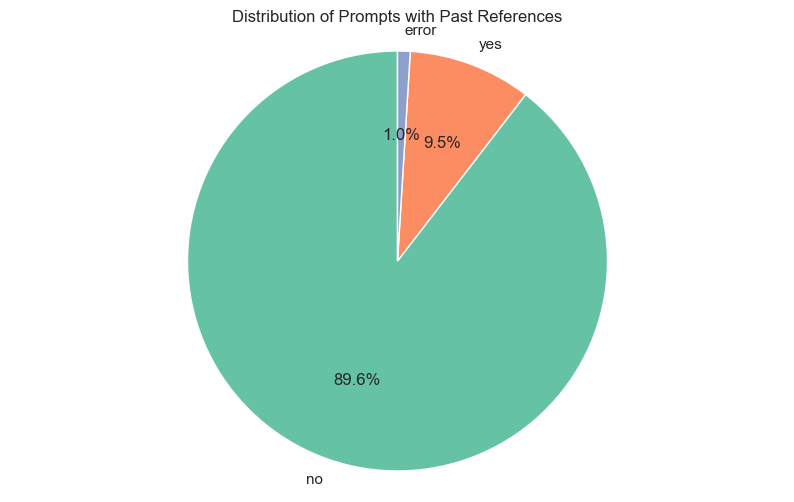

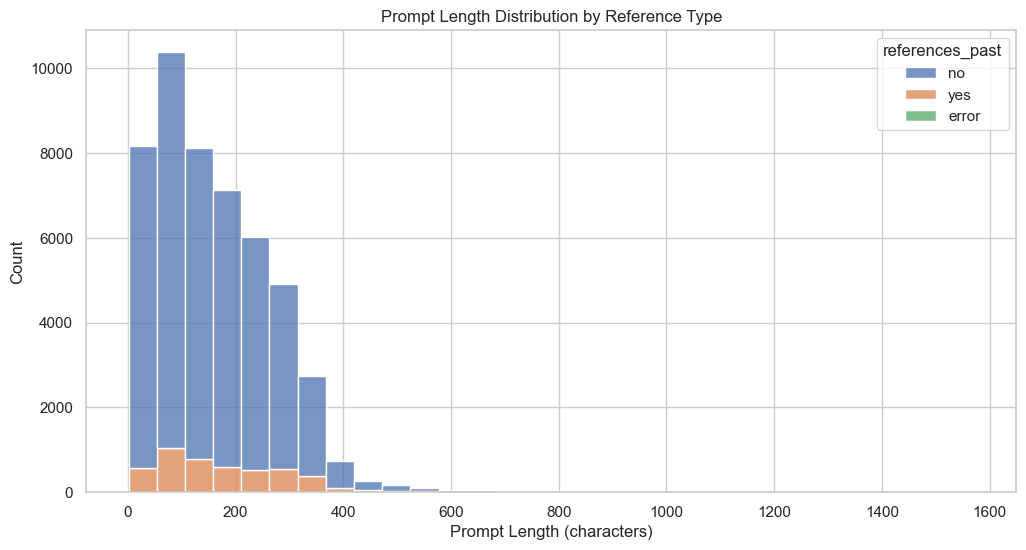

In [10]:
# Visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nicer style
sns.set(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(10, 6))
counts = final_df['references_past'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.axis('equal')
plt.title('Distribution of Prompts with Past References')
plt.show()

# Optionally, if your dataset has other columns (e.g., prompt length, category, etc.)
# You can do more analysis to look for patterns

# Add a prompt length column
final_df['prompt_length'] = final_df['prompt'].str.len()

# Plot prompt length distribution by reference type
plt.figure(figsize=(12, 6))
sns.histplot(data=final_df, x='prompt_length', hue='references_past', multiple='stack', bins=30)
plt.title('Prompt Length Distribution by Reference Type')
plt.xlabel('Prompt Length (characters)')
plt.ylabel('Count')
plt.show()

# Any additional analysis you might want to perform